# Final Experiment (Pain Area Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset, get_class_names
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.RCNN import RCNN
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=10, shuffle=True, random_state=48)
epochs = 100
cnn_auc = []
rnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(783, 1, 350, 35) (783, 5)
(274, 1, 350, 35) (274, 5)


In [5]:
classes = get_class_names('skeleton')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain          403
Lower Body       245
Back Region       73
Upper Body        57
Head and Neck      5
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 2.1452054794520548,
 1: 31.32,
 2: 0.6391836734693878,
 3: 0.38858560794044666,
 4: 2.7473684210526317}

### 1.1 CNN + BiLSTM

Epoch 1/100
22/22 - 36s - loss: 1.8433 - accuracy: 0.2869 - auc: 0.6047 - precision: 0.3704 - recall: 0.0284 - f1_score: 0.1977 - val_loss: 1.3370 - val_accuracy: 0.4177 - val_auc: 0.7872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.2186 - 36s/epoch - 2s/step
Epoch 2/100
22/22 - 2s - loss: 1.3746 - accuracy: 0.4134 - auc: 0.7246 - precision: 0.3656 - recall: 0.0483 - f1_score: 0.2937 - val_loss: 1.1200 - val_accuracy: 0.5696 - val_auc: 0.8573 - val_precision: 0.6667 - val_recall: 0.0253 - val_f1_score: 0.2230 - 2s/epoch - 86ms/step
Epoch 3/100
22/22 - 2s - loss: 1.3179 - accuracy: 0.4261 - auc: 0.7410 - precision: 0.4946 - recall: 0.1293 - f1_score: 0.3083 - val_loss: 1.1184 - val_accuracy: 0.4810 - val_auc: 0.8433 - val_precision: 0.6250 - val_recall: 0.0633 - val_f1_score: 0.3591 - 2s/epoch - 89ms/step
Epoch 4/100
22/22 - 1s - loss: 1.2515 - accuracy: 0.4403 - auc: 0.7631 - precision: 0.5300 - recall: 0.1506 - f1_score: 0.3193 - val_loss: 1.2739 - val_accura

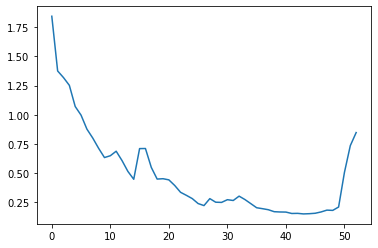

Epoch 1/100
22/22 - 6s - loss: 1.9489 - accuracy: 0.3139 - auc_1: 0.6768 - precision_1: 0.4250 - recall_1: 0.0483 - f1_score: 0.2024 - val_loss: 1.7556 - val_accuracy: 0.0380 - val_auc_1: 0.3354 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0611 - 6s/epoch - 260ms/step
Epoch 2/100
22/22 - 1s - loss: 1.4357 - accuracy: 0.3679 - auc_1: 0.7074 - precision_1: 0.5679 - recall_1: 0.0653 - f1_score: 0.2777 - val_loss: 1.3283 - val_accuracy: 0.4430 - val_auc_1: 0.7767 - val_precision_1: 1.0000 - val_recall_1: 0.0127 - val_f1_score: 0.2590 - 1s/epoch - 68ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2091 - accuracy: 0.4318 - auc_1: 0.7583 - precision_1: 0.5678 - recall_1: 0.1605 - f1_score: 0.3217 - val_loss: 1.2646 - val_accuracy: 0.5063 - val_auc_1: 0.7904 - val_precision_1: 0.7778 - val_recall_1: 0.0886 - val_f1_score: 0.3363 - 1s/epoch - 67ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1222 - accuracy: 0.4929 - auc_1: 0.8091 - precision_1: 0.6221 - recall_1: 0.2642 - f1_sc

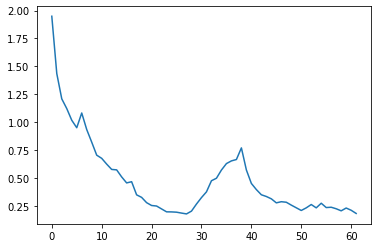

Epoch 1/100
22/22 - 6s - loss: 1.8787 - accuracy: 0.2528 - auc_2: 0.6295 - precision_2: 0.3457 - recall_2: 0.0398 - f1_score: 0.1889 - val_loss: 1.5100 - val_accuracy: 0.3544 - val_auc_2: 0.6914 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1530 - 6s/epoch - 256ms/step
Epoch 2/100
22/22 - 2s - loss: 1.2586 - accuracy: 0.4134 - auc_2: 0.7168 - precision_2: 0.3898 - recall_2: 0.0327 - f1_score: 0.3080 - val_loss: 1.2633 - val_accuracy: 0.4177 - val_auc_2: 0.7738 - val_precision_2: 0.6897 - val_recall_2: 0.2532 - val_f1_score: 0.1861 - 2s/epoch - 68ms/step
Epoch 3/100
22/22 - 1s - loss: 1.3554 - accuracy: 0.4545 - auc_2: 0.7754 - precision_2: 0.5575 - recall_2: 0.1378 - f1_score: 0.3283 - val_loss: 1.4261 - val_accuracy: 0.2911 - val_auc_2: 0.7057 - val_precision_2: 0.2273 - val_recall_2: 0.0633 - val_f1_score: 0.1995 - 1s/epoch - 58ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1218 - accuracy: 0.4531 - auc_2: 0.7794 - precision_2: 0.5611 - recall_2: 0.1761 - f1_sc

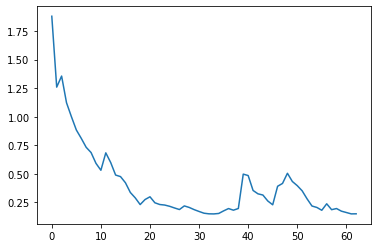

Epoch 1/100
23/23 - 6s - loss: 1.8852 - accuracy: 0.3121 - auc_3: 0.6340 - precision_3: 0.2800 - recall_3: 0.0099 - f1_score: 0.2203 - val_loss: 1.6920 - val_accuracy: 0.2436 - val_auc_3: 0.4255 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1220 - 6s/epoch - 249ms/step
Epoch 2/100
23/23 - 1s - loss: 1.3262 - accuracy: 0.3688 - auc_3: 0.7234 - precision_3: 0.5522 - recall_3: 0.0525 - f1_score: 0.2805 - val_loss: 1.6966 - val_accuracy: 0.2308 - val_auc_3: 0.6110 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1240 - 1s/epoch - 59ms/step
Epoch 3/100
23/23 - 2s - loss: 1.2779 - accuracy: 0.4043 - auc_3: 0.7319 - precision_3: 0.4396 - recall_3: 0.1291 - f1_score: 0.3035 - val_loss: 1.4438 - val_accuracy: 0.2692 - val_auc_3: 0.6643 - val_precision_3: 0.3333 - val_recall_3: 0.0641 - val_f1_score: 0.1265 - 2s/epoch - 68ms/step
Epoch 4/100
23/23 - 2s - loss: 1.0544 - accuracy: 0.4681 - auc_3: 0.7892 - precision_3: 0.5594 - recall_3: 0.1603

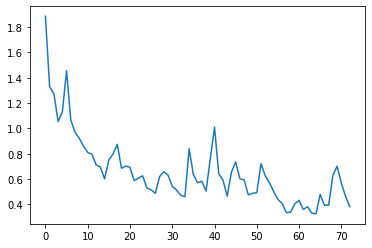

Epoch 1/100
23/23 - 6s - loss: 1.8833 - accuracy: 0.2213 - auc_4: 0.6198 - precision_4: 0.3810 - recall_4: 0.0340 - f1_score: 0.1584 - val_loss: 1.3401 - val_accuracy: 0.6026 - val_auc_4: 0.7977 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1504 - 6s/epoch - 242ms/step
Epoch 2/100
23/23 - 1s - loss: 1.3594 - accuracy: 0.3972 - auc_4: 0.7191 - precision_4: 0.3115 - recall_4: 0.0270 - f1_score: 0.2812 - val_loss: 1.9930 - val_accuracy: 0.0897 - val_auc_4: 0.5181 - val_precision_4: 0.0933 - val_recall_4: 0.0897 - val_f1_score: 0.0329 - 1s/epoch - 59ms/step
Epoch 3/100
23/23 - 1s - loss: 1.3356 - accuracy: 0.3759 - auc_4: 0.7111 - precision_4: 0.4226 - recall_4: 0.1007 - f1_score: 0.2928 - val_loss: 2.0414 - val_accuracy: 0.0897 - val_auc_4: 0.3998 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0548 - 1s/epoch - 59ms/step
Epoch 4/100
23/23 - 1s - loss: 1.2098 - accuracy: 0.4340 - auc_4: 0.7402 - precision_4: 0.4821 - recall_4: 0.1149

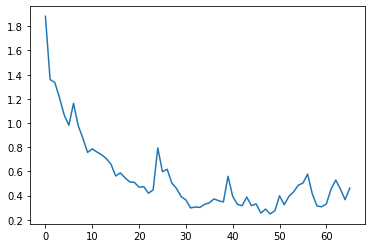

Epoch 1/100
23/23 - 6s - loss: 1.8211 - accuracy: 0.2851 - auc_5: 0.6071 - precision_5: 0.3333 - recall_5: 0.0241 - f1_score: 0.2006 - val_loss: 1.1947 - val_accuracy: 0.5641 - val_auc_5: 0.8265 - val_precision_5: 0.5833 - val_recall_5: 0.5385 - val_f1_score: 0.1443 - 6s/epoch - 254ms/step
Epoch 2/100
23/23 - 1s - loss: 1.2764 - accuracy: 0.4482 - auc_5: 0.7704 - precision_5: 0.6198 - recall_5: 0.1064 - f1_score: 0.3148 - val_loss: 1.2152 - val_accuracy: 0.5641 - val_auc_5: 0.8037 - val_precision_5: 0.6471 - val_recall_5: 0.1410 - val_f1_score: 0.2243 - 1s/epoch - 59ms/step
Epoch 3/100
23/23 - 2s - loss: 1.2656 - accuracy: 0.4411 - auc_5: 0.7638 - precision_5: 0.5546 - recall_5: 0.1801 - f1_score: 0.3137 - val_loss: 1.1381 - val_accuracy: 0.5385 - val_auc_5: 0.8302 - val_precision_5: 0.6400 - val_recall_5: 0.4103 - val_f1_score: 0.1725 - 2s/epoch - 69ms/step
Epoch 4/100
23/23 - 1s - loss: 1.1137 - accuracy: 0.4823 - auc_5: 0.7981 - precision_5: 0.6154 - recall_5: 0.2156 - f1_score: 0.3

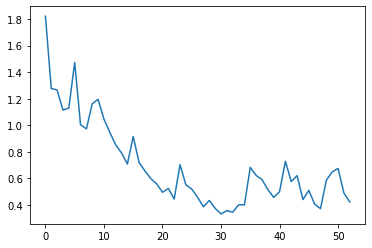

Epoch 1/100
23/23 - 6s - loss: 1.8945 - accuracy: 0.2667 - auc_6: 0.6304 - precision_6: 0.1279 - recall_6: 0.0156 - f1_score: 0.2044 - val_loss: 1.2686 - val_accuracy: 0.5256 - val_auc_6: 0.8123 - val_precision_6: 0.7000 - val_recall_6: 0.0897 - val_f1_score: 0.2911 - 6s/epoch - 255ms/step
Epoch 2/100
23/23 - 1s - loss: 1.3049 - accuracy: 0.4312 - auc_6: 0.7590 - precision_6: 0.6053 - recall_6: 0.0652 - f1_score: 0.3189 - val_loss: 1.3244 - val_accuracy: 0.5000 - val_auc_6: 0.7331 - val_precision_6: 0.5714 - val_recall_6: 0.1538 - val_f1_score: 0.2584 - 1s/epoch - 60ms/step
Epoch 3/100
23/23 - 1s - loss: 1.1671 - accuracy: 0.4539 - auc_6: 0.7753 - precision_6: 0.5463 - recall_6: 0.1589 - f1_score: 0.3278 - val_loss: 2.3580 - val_accuracy: 0.0385 - val_auc_6: 0.4409 - val_precision_6: 0.0435 - val_recall_6: 0.0385 - val_f1_score: 0.0148 - 1s/epoch - 60ms/step
Epoch 4/100
23/23 - 1s - loss: 1.0899 - accuracy: 0.4355 - auc_6: 0.7693 - precision_6: 0.5484 - recall_6: 0.1447 - f1_score: 0.3

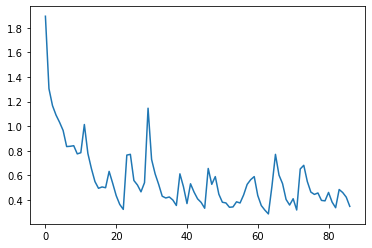

Epoch 1/100
23/23 - 6s - loss: 1.7259 - accuracy: 0.2667 - auc_7: 0.6318 - precision_7: 0.1750 - recall_7: 0.0298 - f1_score: 0.1886 - val_loss: 1.3299 - val_accuracy: 0.4615 - val_auc_7: 0.7845 - val_precision_7: 0.7000 - val_recall_7: 0.0897 - val_f1_score: 0.1263 - 6s/epoch - 250ms/step
Epoch 2/100
23/23 - 1s - loss: 1.3041 - accuracy: 0.4156 - auc_7: 0.7452 - precision_7: 0.4806 - recall_7: 0.0879 - f1_score: 0.2806 - val_loss: 1.5063 - val_accuracy: 0.3077 - val_auc_7: 0.6441 - val_precision_7: 0.3333 - val_recall_7: 0.0513 - val_f1_score: 0.1392 - 1s/epoch - 59ms/step
Epoch 3/100
23/23 - 2s - loss: 1.1988 - accuracy: 0.4355 - auc_7: 0.7581 - precision_7: 0.5356 - recall_7: 0.1816 - f1_score: 0.3250 - val_loss: 1.2453 - val_accuracy: 0.4487 - val_auc_7: 0.7953 - val_precision_7: 0.7500 - val_recall_7: 0.0385 - val_f1_score: 0.2144 - 2s/epoch - 68ms/step
Epoch 4/100
23/23 - 2s - loss: 1.0323 - accuracy: 0.4979 - auc_7: 0.8074 - precision_7: 0.6226 - recall_7: 0.2340 - f1_score: 0.3

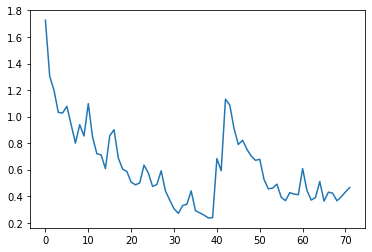

Epoch 1/100
23/23 - 6s - loss: 1.7306 - accuracy: 0.2738 - auc_8: 0.6487 - precision_8: 0.2414 - recall_8: 0.0397 - f1_score: 0.2104 - val_loss: 1.5978 - val_accuracy: 0.3462 - val_auc_8: 0.5955 - val_precision_8: 0.3333 - val_recall_8: 0.0128 - val_f1_score: 0.1115 - 6s/epoch - 253ms/step
Epoch 2/100
23/23 - 2s - loss: 1.2294 - accuracy: 0.4454 - auc_8: 0.7794 - precision_8: 0.5774 - recall_8: 0.1376 - f1_score: 0.3415 - val_loss: 1.2836 - val_accuracy: 0.5128 - val_auc_8: 0.7727 - val_precision_8: 0.8889 - val_recall_8: 0.1026 - val_f1_score: 0.2324 - 2s/epoch - 70ms/step
Epoch 3/100
23/23 - 1s - loss: 1.1607 - accuracy: 0.4936 - auc_8: 0.7977 - precision_8: 0.6339 - recall_8: 0.2014 - f1_score: 0.3675 - val_loss: 1.4030 - val_accuracy: 0.4744 - val_auc_8: 0.7360 - val_precision_8: 0.5625 - val_recall_8: 0.3462 - val_f1_score: 0.1310 - 1s/epoch - 59ms/step
Epoch 4/100
23/23 - 1s - loss: 1.0345 - accuracy: 0.5248 - auc_8: 0.8416 - precision_8: 0.6947 - recall_8: 0.2809 - f1_score: 0.4

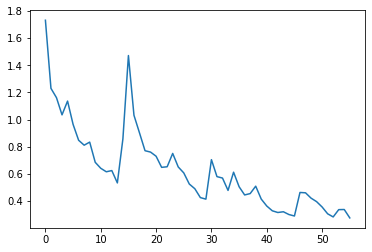

Epoch 1/100
23/23 - 6s - loss: 1.7690 - accuracy: 0.2965 - auc_9: 0.6229 - precision_9: 0.4286 - recall_9: 0.0553 - f1_score: 0.2100 - val_loss: 1.2554 - val_accuracy: 0.5897 - val_auc_9: 0.8470 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.1484 - 6s/epoch - 257ms/step
Epoch 2/100
23/23 - 2s - loss: 1.2603 - accuracy: 0.4255 - auc_9: 0.7418 - precision_9: 0.5904 - recall_9: 0.0695 - f1_score: 0.3139 - val_loss: 1.2159 - val_accuracy: 0.3077 - val_auc_9: 0.7745 - val_precision_9: 1.0000 - val_recall_9: 0.0128 - val_f1_score: 0.1120 - 2s/epoch - 69ms/step
Epoch 3/100
23/23 - 1s - loss: 1.1550 - accuracy: 0.4723 - auc_9: 0.7764 - precision_9: 0.5837 - recall_9: 0.1730 - f1_score: 0.3434 - val_loss: 3.0264 - val_accuracy: 0.0769 - val_auc_9: 0.4554 - val_precision_9: 0.0769 - val_recall_9: 0.0769 - val_f1_score: 0.0286 - 1s/epoch - 59ms/step
Epoch 4/100
23/23 - 2s - loss: 1.3297 - accuracy: 0.3929 - auc_9: 0.7289 - precision_9: 0.3483 - recall_9: 0.0879 - f1_sc

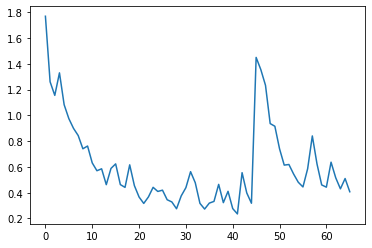

In [7]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_body_model = CNNLSTM(n_features, None, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_body_model.save(model_path / 'body_area_cnnlstm.h5')

#### Training performance

In [8]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.8351092040538788,
 'ROC/AUC': 0.9691992700099945,
 'Precision': 0.865907895565033,
 'Recall': 0.8009167432785034,
 'F1-score': 0.7352396368980407}

#### Validation performance

In [9]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.4927945524454117,
 'ROC/AUC': 0.7725150883197784,
 'Precision': 0.5139438092708588,
 'Recall': 0.4582278519868851,
 'F1-score': 0.2988022267818451}

#### Predictions and performance on test set

In [10]:
cnnlstm_area_body_model = load_model(model_path / 'body_area_cnnlstm.h5')
y_pred = cnnlstm_area_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 15ms/step - loss: 1.9407 - accuracy: 0.2445 - auc_9: 0.6303 - precision_9: 0.2717 - recall_9: 0.1715 - f1_score: 0.1809
Accuracy: 24.45% 
Balanced Accuracy: 22.96% 
ROC/AUC: 0.63 
Precision: 0.27 
Recall: 0.17 
F1 score: 0.18


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

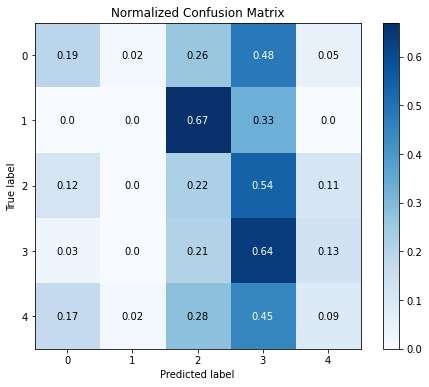

In [11]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

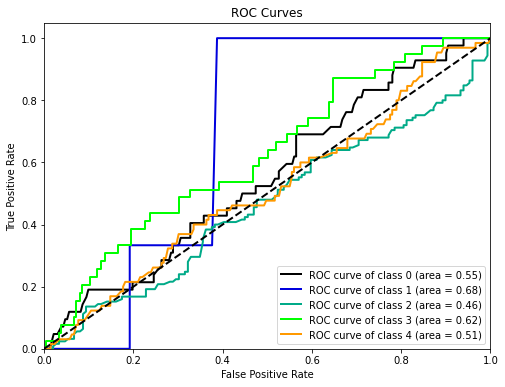

In [12]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

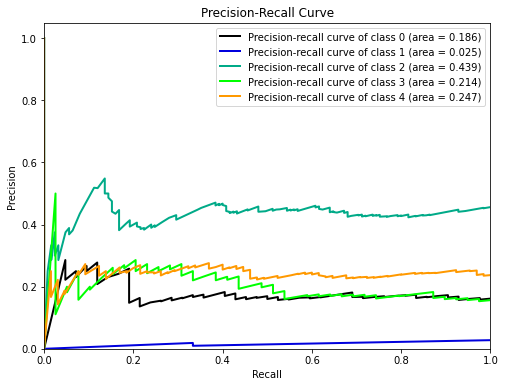

In [13]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

### 1.2 RCNN

Epoch 1/100
22/22 - 2s - loss: 2.1303 - accuracy: 0.2955 - auc_10: 0.6400 - precision_10: 0.2852 - recall_10: 0.1065 - f1_score: 0.2094 - val_loss: 13.6351 - val_accuracy: 0.0127 - val_auc_10: 0.3500 - val_precision_10: 0.0127 - val_recall_10: 0.0127 - val_f1_score: 0.0052 - 2s/epoch - 105ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3656 - accuracy: 0.3352 - auc_10: 0.6921 - precision_10: 0.3484 - recall_10: 0.1094 - f1_score: 0.2537 - val_loss: 11.4942 - val_accuracy: 0.0759 - val_auc_10: 0.4159 - val_precision_10: 0.0759 - val_recall_10: 0.0759 - val_f1_score: 0.0282 - 498ms/epoch - 23ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2823 - accuracy: 0.3849 - auc_10: 0.7188 - precision_10: 0.4453 - recall_10: 0.1562 - f1_score: 0.2997 - val_loss: 3.3851 - val_accuracy: 0.1013 - val_auc_10: 0.5703 - val_precision_10: 0.0921 - val_recall_10: 0.0886 - val_f1_score: 0.0522 - 486ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.1376 - accuracy: 0.4588 - auc_10: 0.7821 - precision_10: 0.5714 - reca

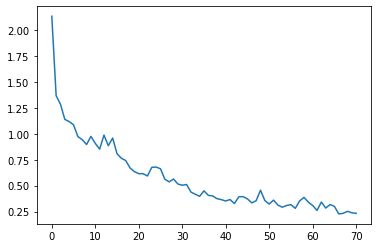

Epoch 1/100
22/22 - 2s - loss: 2.1183 - accuracy: 0.2741 - auc_11: 0.6252 - precision_11: 0.2712 - recall_11: 0.0909 - f1_score: 0.1874 - val_loss: 18.0462 - val_accuracy: 0.1139 - val_auc_11: 0.4299 - val_precision_11: 0.1139 - val_recall_11: 0.1139 - val_f1_score: 0.0414 - 2s/epoch - 103ms/step
Epoch 2/100
22/22 - 0s - loss: 1.4877 - accuracy: 0.3977 - auc_11: 0.7088 - precision_11: 0.4770 - recall_11: 0.1619 - f1_score: 0.2904 - val_loss: 3.8601 - val_accuracy: 0.0886 - val_auc_11: 0.4392 - val_precision_11: 0.0968 - val_recall_11: 0.0759 - val_f1_score: 0.0503 - 494ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2079 - accuracy: 0.4105 - auc_11: 0.7357 - precision_11: 0.5079 - recall_11: 0.1818 - f1_score: 0.3164 - val_loss: 4.8153 - val_accuracy: 0.0886 - val_auc_11: 0.5038 - val_precision_11: 0.0897 - val_recall_11: 0.0886 - val_f1_score: 0.0329 - 471ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.1706 - accuracy: 0.4716 - auc_11: 0.7816 - precision_11: 0.5455 - recal

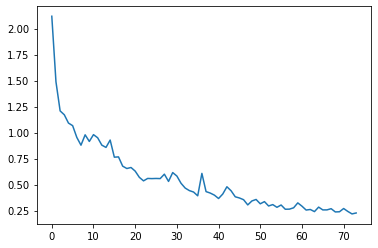

Epoch 1/100
22/22 - 2s - loss: 2.1899 - accuracy: 0.2230 - auc_12: 0.5869 - precision_12: 0.2074 - recall_12: 0.0795 - f1_score: 0.1635 - val_loss: 5.0178 - val_accuracy: 0.0633 - val_auc_12: 0.4193 - val_precision_12: 0.0154 - val_recall_12: 0.0127 - val_f1_score: 0.0674 - 2s/epoch - 109ms/step
Epoch 2/100
22/22 - 0s - loss: 1.2237 - accuracy: 0.3580 - auc_12: 0.7076 - precision_12: 0.3757 - recall_12: 0.1009 - f1_score: 0.2671 - val_loss: 2.0014 - val_accuracy: 0.3671 - val_auc_12: 0.6975 - val_precision_12: 0.3636 - val_recall_12: 0.3038 - val_f1_score: 0.2260 - 494ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.3172 - accuracy: 0.4418 - auc_12: 0.7639 - precision_12: 0.4912 - recall_12: 0.1989 - f1_score: 0.3240 - val_loss: 3.1650 - val_accuracy: 0.1646 - val_auc_12: 0.5315 - val_precision_12: 0.1642 - val_recall_12: 0.1392 - val_f1_score: 0.1273 - 486ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.0823 - accuracy: 0.4702 - auc_12: 0.7897 - precision_12: 0.5728 - recall

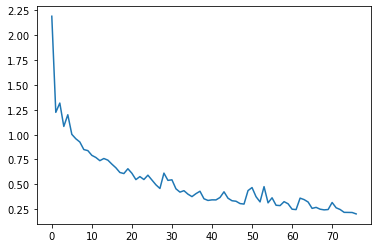

Epoch 1/100
23/23 - 2s - loss: 2.0330 - accuracy: 0.2567 - auc_13: 0.5939 - precision_13: 0.2394 - recall_13: 0.0879 - f1_score: 0.1924 - val_loss: 3.9512 - val_accuracy: 0.5256 - val_auc_13: 0.6923 - val_precision_13: 0.5256 - val_recall_13: 0.5256 - val_f1_score: 0.1378 - 2s/epoch - 103ms/step
Epoch 2/100
23/23 - 0s - loss: 1.4662 - accuracy: 0.3546 - auc_13: 0.6969 - precision_13: 0.4044 - recall_13: 0.1291 - f1_score: 0.2596 - val_loss: 18.3117 - val_accuracy: 0.1154 - val_auc_13: 0.3678 - val_precision_13: 0.1154 - val_recall_13: 0.1154 - val_f1_score: 0.1043 - 446ms/epoch - 19ms/step
Epoch 3/100
23/23 - 0s - loss: 1.5182 - accuracy: 0.3830 - auc_13: 0.7160 - precision_13: 0.3710 - recall_13: 0.1631 - f1_score: 0.2856 - val_loss: 3.8409 - val_accuracy: 0.1795 - val_auc_13: 0.4867 - val_precision_13: 0.1875 - val_recall_13: 0.1538 - val_f1_score: 0.1174 - 463ms/epoch - 20ms/step
Epoch 4/100
23/23 - 0s - loss: 1.2567 - accuracy: 0.4298 - auc_13: 0.7528 - precision_13: 0.4876 - recal

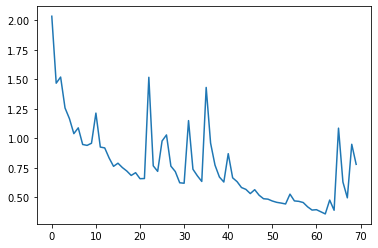

Epoch 1/100
23/23 - 2s - loss: 2.0443 - accuracy: 0.2582 - auc_14: 0.5815 - precision_14: 0.2511 - recall_14: 0.0823 - f1_score: 0.1939 - val_loss: 14.8924 - val_accuracy: 0.2179 - val_auc_14: 0.5085 - val_precision_14: 0.2179 - val_recall_14: 0.2179 - val_f1_score: 0.0716 - 2s/epoch - 101ms/step
Epoch 2/100
23/23 - 0s - loss: 1.4293 - accuracy: 0.3660 - auc_14: 0.6986 - precision_14: 0.3968 - recall_14: 0.1745 - f1_score: 0.2811 - val_loss: 3.2227 - val_accuracy: 0.2051 - val_auc_14: 0.6524 - val_precision_14: 0.2051 - val_recall_14: 0.2051 - val_f1_score: 0.0994 - 477ms/epoch - 21ms/step
Epoch 3/100
23/23 - 0s - loss: 1.2208 - accuracy: 0.4369 - auc_14: 0.7648 - precision_14: 0.5276 - recall_14: 0.2440 - f1_score: 0.3357 - val_loss: 7.3822 - val_accuracy: 0.1667 - val_auc_14: 0.4038 - val_precision_14: 0.1688 - val_recall_14: 0.1667 - val_f1_score: 0.1056 - 460ms/epoch - 20ms/step
Epoch 4/100
23/23 - 0s - loss: 1.1482 - accuracy: 0.4681 - auc_14: 0.7871 - precision_14: 0.5406 - recal

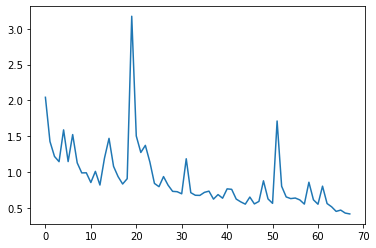

Epoch 1/100
23/23 - 3s - loss: 2.2391 - accuracy: 0.2794 - auc_15: 0.6159 - precision_15: 0.2791 - recall_15: 0.0851 - f1_score: 0.1964 - val_loss: 4.9064 - val_accuracy: 0.5513 - val_auc_15: 0.7384 - val_precision_15: 0.5513 - val_recall_15: 0.5513 - val_f1_score: 0.1709 - 3s/epoch - 111ms/step
Epoch 2/100
23/23 - 0s - loss: 1.3987 - accuracy: 0.3716 - auc_15: 0.7010 - precision_15: 0.4586 - recall_15: 0.1730 - f1_score: 0.2777 - val_loss: 28.8303 - val_accuracy: 0.1410 - val_auc_15: 0.4631 - val_precision_15: 0.1410 - val_recall_15: 0.1410 - val_f1_score: 0.0494 - 463ms/epoch - 20ms/step
Epoch 3/100
23/23 - 0s - loss: 1.3259 - accuracy: 0.3461 - auc_15: 0.6950 - precision_15: 0.3891 - recall_15: 0.1518 - f1_score: 0.2714 - val_loss: 7.0194 - val_accuracy: 0.2308 - val_auc_15: 0.4714 - val_precision_15: 0.2308 - val_recall_15: 0.2308 - val_f1_score: 0.0750 - 443ms/epoch - 19ms/step
Epoch 4/100
23/23 - 0s - loss: 1.1756 - accuracy: 0.4610 - auc_15: 0.7784 - precision_15: 0.5644 - recal

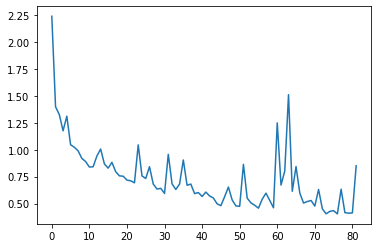

Epoch 1/100
23/23 - 2s - loss: 2.1208 - accuracy: 0.3191 - auc_16: 0.6456 - precision_16: 0.3171 - recall_16: 0.1106 - f1_score: 0.2337 - val_loss: 10.1556 - val_accuracy: 0.3974 - val_auc_16: 0.6328 - val_precision_16: 0.3974 - val_recall_16: 0.3974 - val_f1_score: 0.1159 - 2s/epoch - 101ms/step
Epoch 2/100
23/23 - 0s - loss: 1.3534 - accuracy: 0.3305 - auc_16: 0.6828 - precision_16: 0.3604 - recall_16: 0.1007 - f1_score: 0.2474 - val_loss: 8.0765 - val_accuracy: 0.0513 - val_auc_16: 0.3967 - val_precision_16: 0.0513 - val_recall_16: 0.0513 - val_f1_score: 0.0245 - 464ms/epoch - 20ms/step
Epoch 3/100
23/23 - 0s - loss: 1.2283 - accuracy: 0.4113 - auc_16: 0.7330 - precision_16: 0.4701 - recall_16: 0.1787 - f1_score: 0.3097 - val_loss: 5.5029 - val_accuracy: 0.0513 - val_auc_16: 0.5212 - val_precision_16: 0.0513 - val_recall_16: 0.0513 - val_f1_score: 0.0245 - 470ms/epoch - 20ms/step
Epoch 4/100
23/23 - 0s - loss: 1.1491 - accuracy: 0.4454 - auc_16: 0.7743 - precision_16: 0.5700 - recal

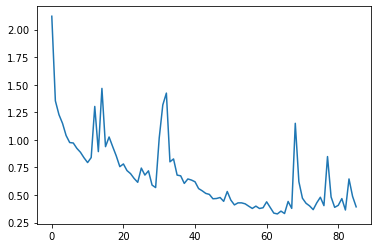

Epoch 1/100
23/23 - 2s - loss: 2.2400 - accuracy: 0.3021 - auc_17: 0.6435 - precision_17: 0.3062 - recall_17: 0.1603 - f1_score: 0.2154 - val_loss: 14.5086 - val_accuracy: 0.0897 - val_auc_17: 0.3697 - val_precision_17: 0.0933 - val_recall_17: 0.0897 - val_f1_score: 0.0622 - 2s/epoch - 96ms/step
Epoch 2/100
23/23 - 0s - loss: 1.4618 - accuracy: 0.3433 - auc_17: 0.6788 - precision_17: 0.3258 - recall_17: 0.1234 - f1_score: 0.2677 - val_loss: 37.8004 - val_accuracy: 0.0897 - val_auc_17: 0.4311 - val_precision_17: 0.0897 - val_recall_17: 0.0897 - val_f1_score: 0.0329 - 418ms/epoch - 18ms/step
Epoch 3/100
23/23 - 0s - loss: 1.7238 - accuracy: 0.2596 - auc_17: 0.5964 - precision_17: 0.2400 - recall_17: 0.1106 - f1_score: 0.2152 - val_loss: 3.9416 - val_accuracy: 0.2949 - val_auc_17: 0.5716 - val_precision_17: 0.3026 - val_recall_17: 0.2949 - val_f1_score: 0.0929 - 426ms/epoch - 19ms/step
Epoch 4/100
23/23 - 0s - loss: 1.2880 - accuracy: 0.3872 - auc_17: 0.7308 - precision_17: 0.4314 - recal

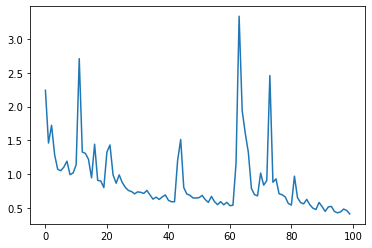

Epoch 1/100
23/23 - 2s - loss: 2.1009 - accuracy: 0.2667 - auc_18: 0.6278 - precision_18: 0.3158 - recall_18: 0.1277 - f1_score: 0.1901 - val_loss: 45.3033 - val_accuracy: 0.1026 - val_auc_18: 0.4391 - val_precision_18: 0.1026 - val_recall_18: 0.1026 - val_f1_score: 0.0372 - 2s/epoch - 105ms/step
Epoch 2/100
23/23 - 0s - loss: 1.4124 - accuracy: 0.3660 - auc_18: 0.7025 - precision_18: 0.3915 - recall_18: 0.1433 - f1_score: 0.2761 - val_loss: 3.2126 - val_accuracy: 0.2692 - val_auc_18: 0.5684 - val_precision_18: 0.2778 - val_recall_18: 0.2564 - val_f1_score: 0.1420 - 429ms/epoch - 19ms/step
Epoch 3/100
23/23 - 0s - loss: 1.2816 - accuracy: 0.3957 - auc_18: 0.7358 - precision_18: 0.4424 - recall_18: 0.1745 - f1_score: 0.2897 - val_loss: 1.6508 - val_accuracy: 0.4103 - val_auc_18: 0.7482 - val_precision_18: 0.4259 - val_recall_18: 0.2949 - val_f1_score: 0.2099 - 423ms/epoch - 18ms/step
Epoch 4/100
23/23 - 0s - loss: 1.2532 - accuracy: 0.4695 - auc_18: 0.7743 - precision_18: 0.5510 - recal

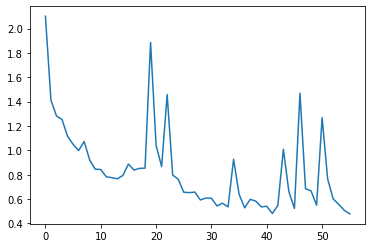

Epoch 1/100
23/23 - 2s - loss: 2.1185 - accuracy: 0.2738 - auc_19: 0.5733 - precision_19: 0.2899 - recall_19: 0.0979 - f1_score: 0.1987 - val_loss: 5.8255 - val_accuracy: 0.5641 - val_auc_19: 0.7259 - val_precision_19: 0.5641 - val_recall_19: 0.5641 - val_f1_score: 0.1972 - 2s/epoch - 96ms/step
Epoch 2/100
23/23 - 0s - loss: 1.4107 - accuracy: 0.3617 - auc_19: 0.7065 - precision_19: 0.3919 - recall_19: 0.1234 - f1_score: 0.2670 - val_loss: 3.8101 - val_accuracy: 0.0897 - val_auc_19: 0.4717 - val_precision_19: 0.0800 - val_recall_19: 0.0769 - val_f1_score: 0.0450 - 425ms/epoch - 18ms/step
Epoch 3/100
23/23 - 0s - loss: 1.2087 - accuracy: 0.4184 - auc_19: 0.7510 - precision_19: 0.5526 - recall_19: 0.2085 - f1_score: 0.3071 - val_loss: 6.0752 - val_accuracy: 0.0513 - val_auc_19: 0.4752 - val_precision_19: 0.0513 - val_recall_19: 0.0513 - val_f1_score: 0.0195 - 408ms/epoch - 18ms/step
Epoch 4/100
23/23 - 0s - loss: 1.1167 - accuracy: 0.4525 - auc_19: 0.7679 - precision_19: 0.5249 - recall_

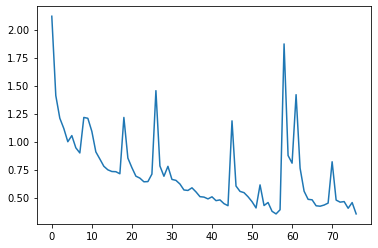

In [14]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_body_model = RCNN(n_features, None, n_length, n_outputs, multiclass=True)
    history = rcnn_area_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_body_model.save(model_path / 'body_area_rcnn.h5')

#### Training performance

In [15]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.8232348084449768,
 'ROC/AUC': 0.9619194447994233,
 'Precision': 0.8516062259674072,
 'Recall': 0.7748619794845581,
 'F1-score': 0.7606151461601257}

#### Validation performance

In [16]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.48122363686561587,
 'ROC/AUC': 0.8008205354213714,
 'Precision': 0.4996089726686478,
 'Recall': 0.44795521199703214,
 'F1-score': 0.2915587767958641}

#### Predictions and performance on test set

In [17]:
rcnn_area_body_model = load_model(model_path / 'body_area_rcnn.h5')
y_pred = rcnn_area_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 9ms/step - loss: 2.4254 - accuracy: 0.2190 - auc_12: 0.6154 - precision_12: 0.2261 - recall_12: 0.1642 - f1_score: 0.1266
Accuracy: 21.90% 
Balanced Accuracy: 19.22% 
ROC/AUC: 0.62 
Precision: 0.23 
Recall: 0.16 
F1 score: 0.13


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

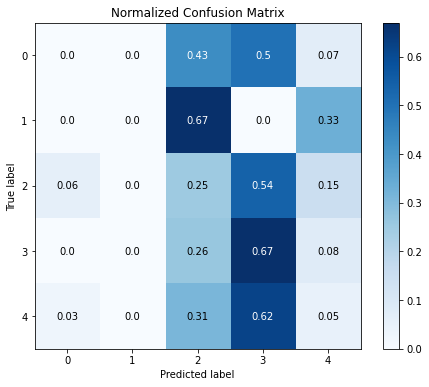

In [18]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

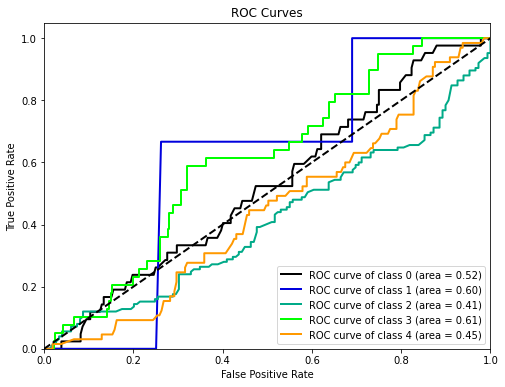

In [19]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

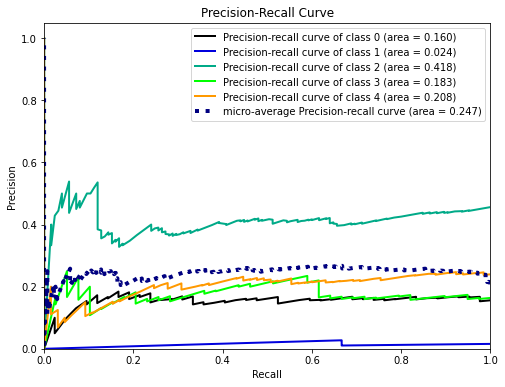

In [20]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

## 2. Unimodal Face (Facial Expression + Head Pose)

In [21]:
X_train, X_test, y_train, y_test = load_dataset('AUs')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 25) (752, 5)
(268, 1, 350, 25) (268, 5)


In [22]:
classes = get_class_names('AUs')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain          386
Lower Body       236
Back Region       69
Upper Body        57
Head and Neck      4
dtype: int64

In [23]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 2.1797101449275362,
 1: 37.6,
 2: 0.6372881355932203,
 3: 0.38963730569948185,
 4: 2.6385964912280704}

### 2.1 CNN + BiLSTM

Epoch 1/100
22/22 - 6s - loss: 2.0178 - accuracy: 0.3299 - auc_20: 0.6406 - precision_20: 0.2987 - recall_20: 0.0340 - f1_score: 0.2385 - val_loss: 1.4750 - val_accuracy: 0.4605 - val_auc_20: 0.7077 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1860 - 6s/epoch - 271ms/step
Epoch 2/100
22/22 - 1s - loss: 1.4542 - accuracy: 0.4334 - auc_20: 0.7189 - precision_20: 0.4545 - recall_20: 0.0444 - f1_score: 0.2930 - val_loss: 1.6687 - val_accuracy: 0.1974 - val_auc_20: 0.5307 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1662 - 1s/epoch - 58ms/step
Epoch 3/100
22/22 - 2s - loss: 1.3324 - accuracy: 0.3728 - auc_20: 0.7015 - precision_20: 0.3728 - recall_20: 0.0932 - f1_score: 0.2989 - val_loss: 1.4022 - val_accuracy: 0.3947 - val_auc_20: 0.7263 - val_precision_20: 0.3750 - val_recall_20: 0.0395 - val_f1_score: 0.1710 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 1s - loss: 1.2235 - accuracy: 0.4734 - auc_20: 0.7748 - precision_20: 0.534

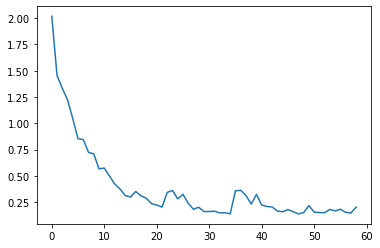

Epoch 1/100
22/22 - 6s - loss: 1.9542 - accuracy: 0.3166 - auc_21: 0.6571 - precision_21: 0.5182 - recall_21: 0.1050 - f1_score: 0.2090 - val_loss: 1.5730 - val_accuracy: 0.4079 - val_auc_21: 0.6315 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.1253 - 6s/epoch - 257ms/step
Epoch 2/100
22/22 - 1s - loss: 1.4312 - accuracy: 0.4142 - auc_21: 0.7222 - precision_21: 0.5532 - recall_21: 0.0385 - f1_score: 0.3007 - val_loss: 1.6961 - val_accuracy: 0.2368 - val_auc_21: 0.5323 - val_precision_21: 0.5000 - val_recall_21: 0.0132 - val_f1_score: 0.1067 - 1s/epoch - 58ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2131 - accuracy: 0.4157 - auc_21: 0.7436 - precision_21: 0.5663 - recall_21: 0.1391 - f1_score: 0.3181 - val_loss: 1.4463 - val_accuracy: 0.3289 - val_auc_21: 0.6964 - val_precision_21: 0.1429 - val_recall_21: 0.0132 - val_f1_score: 0.1770 - 1s/epoch - 68ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1805 - accuracy: 0.4645 - auc_21: 0.7974 - precision_21: 0.5932 - reca

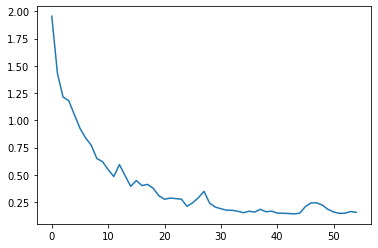

Epoch 1/100
22/22 - 6s - loss: 1.8225 - accuracy: 0.2762 - auc_22: 0.5863 - precision_22: 0.1940 - recall_22: 0.0192 - f1_score: 0.1948 - val_loss: 1.4714 - val_accuracy: 0.4667 - val_auc_22: 0.7389 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.2043 - 6s/epoch - 251ms/step
Epoch 2/100
22/22 - 1s - loss: 1.4963 - accuracy: 0.4180 - auc_22: 0.7071 - precision_22: 0.6500 - recall_22: 0.0384 - f1_score: 0.2901 - val_loss: 1.6731 - val_accuracy: 0.0267 - val_auc_22: 0.4869 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.0145 - 1s/epoch - 58ms/step
Epoch 3/100
22/22 - 2s - loss: 1.2729 - accuracy: 0.3885 - auc_22: 0.7348 - precision_22: 0.5188 - recall_22: 0.1019 - f1_score: 0.3015 - val_loss: 1.2076 - val_accuracy: 0.5200 - val_auc_22: 0.8159 - val_precision_22: 0.7778 - val_recall_22: 0.0933 - val_f1_score: 0.2189 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1583 - accuracy: 0.4934 - auc_22: 0.7891 - precision_22: 0.596

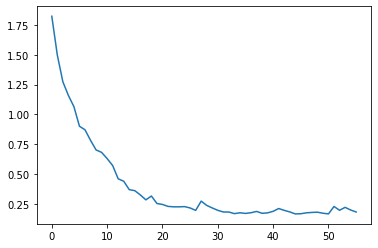

Epoch 1/100
22/22 - 6s - loss: 2.0162 - accuracy: 0.2880 - auc_23: 0.6450 - precision_23: 0.4222 - recall_23: 0.0842 - f1_score: 0.2081 - val_loss: 1.4292 - val_accuracy: 0.4400 - val_auc_23: 0.7449 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.2468 - 6s/epoch - 287ms/step
Epoch 2/100
22/22 - 2s - loss: 1.3622 - accuracy: 0.3988 - auc_23: 0.7282 - precision_23: 0.3768 - recall_23: 0.0384 - f1_score: 0.2978 - val_loss: 1.2877 - val_accuracy: 0.4400 - val_auc_23: 0.7750 - val_precision_23: 1.0000 - val_recall_23: 0.0133 - val_f1_score: 0.2300 - 2s/epoch - 70ms/step
Epoch 3/100
22/22 - 1s - loss: 1.3321 - accuracy: 0.4579 - auc_23: 0.7660 - precision_23: 0.4820 - recall_23: 0.0990 - f1_score: 0.3436 - val_loss: 1.3171 - val_accuracy: 0.4400 - val_auc_23: 0.7614 - val_precision_23: 0.4444 - val_recall_23: 0.0533 - val_f1_score: 0.2527 - 1s/epoch - 58ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0622 - accuracy: 0.4860 - auc_23: 0.7996 - precision_23: 0.6015 - reca

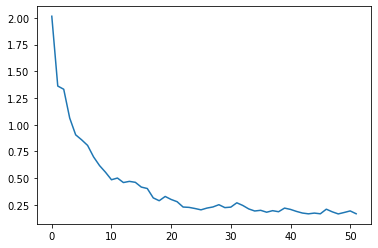

Epoch 1/100
22/22 - 5s - loss: 1.8541 - accuracy: 0.3442 - auc_24: 0.7019 - precision_24: 0.4148 - recall_24: 0.0827 - f1_score: 0.2331 - val_loss: 1.4809 - val_accuracy: 0.2533 - val_auc_24: 0.7020 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.1052 - 5s/epoch - 248ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3733 - accuracy: 0.4343 - auc_24: 0.7287 - precision_24: 0.7404 - recall_24: 0.1137 - f1_score: 0.2993 - val_loss: 1.6382 - val_accuracy: 0.1200 - val_auc_24: 0.5808 - val_precision_24: 0.1250 - val_recall_24: 0.0133 - val_f1_score: 0.0499 - 1s/epoch - 58ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2891 - accuracy: 0.4195 - auc_24: 0.7492 - precision_24: 0.6992 - recall_24: 0.1270 - f1_score: 0.3041 - val_loss: 1.5032 - val_accuracy: 0.2400 - val_auc_24: 0.6605 - val_precision_24: 0.3333 - val_recall_24: 0.0400 - val_f1_score: 0.1050 - 1s/epoch - 58ms/step
Epoch 4/100
22/22 - 2s - loss: 1.1008 - accuracy: 0.4963 - auc_24: 0.8106 - precision_24: 0.6733 - reca

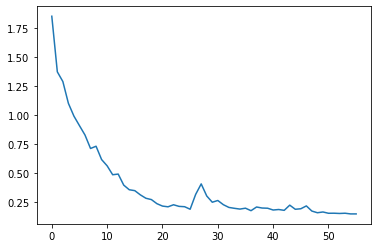

Epoch 1/100
22/22 - 6s - loss: 1.7866 - accuracy: 0.2851 - auc_25: 0.6282 - precision_25: 0.1892 - recall_25: 0.0207 - f1_score: 0.1976 - val_loss: 1.6957 - val_accuracy: 0.0667 - val_auc_25: 0.4841 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.0250 - 6s/epoch - 265ms/step
Epoch 2/100
22/22 - 2s - loss: 1.3622 - accuracy: 0.3840 - auc_25: 0.7136 - precision_25: 0.5507 - recall_25: 0.0561 - f1_score: 0.2872 - val_loss: 1.3873 - val_accuracy: 0.2800 - val_auc_25: 0.7326 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.2370 - 2s/epoch - 70ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2647 - accuracy: 0.4446 - auc_25: 0.7703 - precision_25: 0.5502 - recall_25: 0.1861 - f1_score: 0.3309 - val_loss: 1.6832 - val_accuracy: 0.1733 - val_auc_25: 0.6342 - val_precision_25: 0.0571 - val_recall_25: 0.0267 - val_f1_score: 0.2027 - 1s/epoch - 60ms/step
Epoch 4/100
22/22 - 2s - loss: 1.0737 - accuracy: 0.4860 - auc_25: 0.7999 - precision_25: 0.567

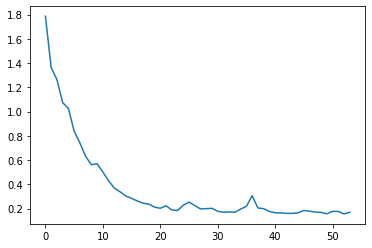

Epoch 1/100
22/22 - 6s - loss: 1.9665 - accuracy: 0.2363 - auc_26: 0.6131 - precision_26: 0.3608 - recall_26: 0.0517 - f1_score: 0.1715 - val_loss: 1.5344 - val_accuracy: 0.4800 - val_auc_26: 0.7010 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.1385 - 6s/epoch - 265ms/step
Epoch 2/100
22/22 - 2s - loss: 1.5259 - accuracy: 0.4165 - auc_26: 0.6996 - precision_26: 0.5833 - recall_26: 0.0103 - f1_score: 0.2956 - val_loss: 1.4366 - val_accuracy: 0.4667 - val_auc_26: 0.7726 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.2951 - 2s/epoch - 70ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2945 - accuracy: 0.4018 - auc_26: 0.7357 - precision_26: 0.5644 - recall_26: 0.0842 - f1_score: 0.3021 - val_loss: 1.7111 - val_accuracy: 0.1200 - val_auc_26: 0.5905 - val_precision_26: 0.1143 - val_recall_26: 0.0533 - val_f1_score: 0.1106 - 1s/epoch - 59ms/step
Epoch 4/100
22/22 - 2s - loss: 1.3279 - accuracy: 0.4372 - auc_26: 0.7542 - precision_26: 0.571

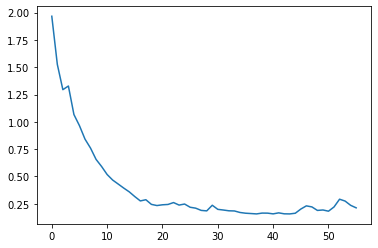

Epoch 1/100
22/22 - 6s - loss: 2.2233 - accuracy: 0.3530 - auc_27: 0.6764 - precision_27: 0.3878 - recall_27: 0.0561 - f1_score: 0.2308 - val_loss: 1.5896 - val_accuracy: 0.3200 - val_auc_27: 0.5557 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_f1_score: 0.1519 - 6s/epoch - 252ms/step
Epoch 2/100
22/22 - 2s - loss: 1.4789 - accuracy: 0.4018 - auc_27: 0.7180 - precision_27: 0.7179 - recall_27: 0.0414 - f1_score: 0.2878 - val_loss: 1.4866 - val_accuracy: 0.3733 - val_auc_27: 0.6832 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_f1_score: 0.1570 - 2s/epoch - 69ms/step
Epoch 3/100
22/22 - 2s - loss: 1.2568 - accuracy: 0.4372 - auc_27: 0.7573 - precision_27: 0.5376 - recall_27: 0.1477 - f1_score: 0.3429 - val_loss: 1.4629 - val_accuracy: 0.2800 - val_auc_27: 0.7314 - val_precision_27: 0.3200 - val_recall_27: 0.2133 - val_f1_score: 0.0903 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 2s - loss: 1.1443 - accuracy: 0.5022 - auc_27: 0.8096 - precision_27: 0.633

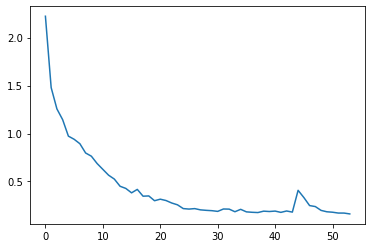

Epoch 1/100
22/22 - 6s - loss: 2.1282 - accuracy: 0.3205 - auc_28: 0.6373 - precision_28: 0.2529 - recall_28: 0.0325 - f1_score: 0.2112 - val_loss: 1.5690 - val_accuracy: 0.3867 - val_auc_28: 0.5777 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_f1_score: 0.1613 - 6s/epoch - 264ms/step
Epoch 2/100
22/22 - 1s - loss: 1.5096 - accuracy: 0.4047 - auc_28: 0.7124 - precision_28: 0.3684 - recall_28: 0.0103 - f1_score: 0.2777 - val_loss: 1.5946 - val_accuracy: 0.4000 - val_auc_28: 0.5447 - val_precision_28: 1.0000 - val_recall_28: 0.0267 - val_f1_score: 0.1967 - 1s/epoch - 59ms/step
Epoch 3/100
22/22 - 1s - loss: 1.3390 - accuracy: 0.3929 - auc_28: 0.7383 - precision_28: 0.4264 - recall_28: 0.0812 - f1_score: 0.3022 - val_loss: 1.9032 - val_accuracy: 0.2400 - val_auc_28: 0.5411 - val_precision_28: 0.2037 - val_recall_28: 0.1467 - val_f1_score: 0.1302 - 1s/epoch - 59ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1170 - accuracy: 0.4520 - auc_28: 0.7746 - precision_28: 0.5422 - reca

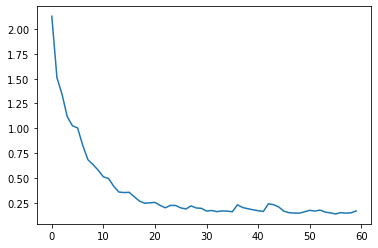

Epoch 1/100
22/22 - 6s - loss: 1.9370 - accuracy: 0.2629 - auc_29: 0.5749 - precision_29: 0.2340 - recall_29: 0.0162 - f1_score: 0.1958 - val_loss: 1.4554 - val_accuracy: 0.2400 - val_auc_29: 0.6937 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.0774 - 6s/epoch - 261ms/step
Epoch 2/100
22/22 - 2s - loss: 1.4445 - accuracy: 0.4018 - auc_29: 0.7294 - precision_29: 0.6078 - recall_29: 0.0458 - f1_score: 0.2886 - val_loss: 1.2740 - val_accuracy: 0.4267 - val_auc_29: 0.7852 - val_precision_29: 0.8125 - val_recall_29: 0.1733 - val_f1_score: 0.1548 - 2s/epoch - 69ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2850 - accuracy: 0.4284 - auc_29: 0.7563 - precision_29: 0.6054 - recall_29: 0.1315 - f1_score: 0.3137 - val_loss: 1.4736 - val_accuracy: 0.3333 - val_auc_29: 0.7213 - val_precision_29: 0.3200 - val_recall_29: 0.2133 - val_f1_score: 0.1412 - 1s/epoch - 59ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0494 - accuracy: 0.5066 - auc_29: 0.8084 - precision_29: 0.6667 - reca

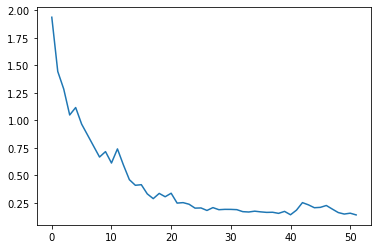

In [24]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_face_model = CNNLSTM(n_features, None, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_face_model.save(model_path / 'face_area_cnnlstm.h5')

#### Training performance

In [25]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.9379410564899444,
 'ROC/AUC': 0.9962669134140014,
 'Precision': 0.9400323987007141,
 'Recall': 0.9360203862190246,
 'F1-score': 0.8510448634624481}

#### Validation performance

In [26]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.5039824545383453,
 'ROC/AUC': 0.7699366390705109,
 'Precision': 0.5285286575555801,
 'Recall': 0.4920175462961197,
 'F1-score': 0.31003143489360807}

#### Predictions and performance on test set

In [27]:
cnnlstm_area_face_model = load_model(model_path / 'face_area_cnnlstm.h5')
y_pred = cnnlstm_area_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 15ms/step - loss: 1.9408 - accuracy: 0.3246 - auc_28: 0.6611 - precision_28: 0.3316 - recall_28: 0.2351 - f1_score: 0.2182
Accuracy: 32.46% 
ROC/AUC: 0.66 
Precision: 0.33 
Recall: 0.24 
F1 score: 0.22


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

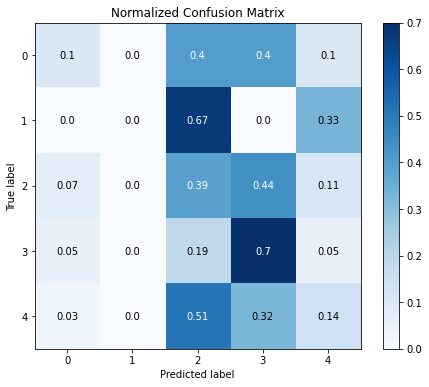

In [28]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

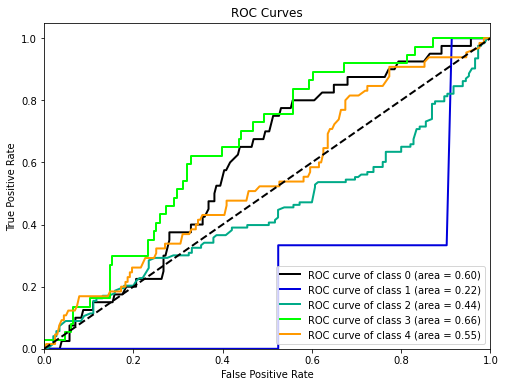

In [29]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

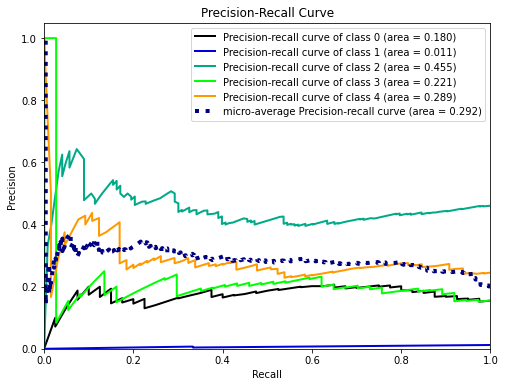

In [30]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

### 2.2 RCNN

Epoch 1/100
22/22 - 2s - loss: 0.5476 - accuracy: 0.4453 - auc_30: 0.7169 - precision_30: 0.4022 - recall_30: 0.3284 - f1_score: 0.2013 - val_loss: 0.4820 - val_accuracy: 0.4474 - val_auc_30: 0.7971 - val_precision_30: 0.4545 - val_recall_30: 0.4605 - val_f1_score: 0.1236 - 2s/epoch - 108ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4469 - accuracy: 0.4882 - auc_30: 0.7823 - precision_30: 0.4965 - recall_30: 0.4201 - f1_score: 0.2404 - val_loss: 0.4363 - val_accuracy: 0.4474 - val_auc_30: 0.7848 - val_precision_30: 0.4474 - val_recall_30: 0.4474 - val_f1_score: 0.1236 - 467ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4511 - accuracy: 0.5074 - auc_30: 0.7927 - precision_30: 0.5331 - recall_30: 0.2737 - f1_score: 0.2234 - val_loss: 0.4175 - val_accuracy: 0.4474 - val_auc_30: 0.8066 - val_precision_30: 0.4776 - val_recall_30: 0.4211 - val_f1_score: 0.1236 - 474ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4114 - accuracy: 0.5251 - auc_30: 0.8058 - precision_30: 0.5403 - recall

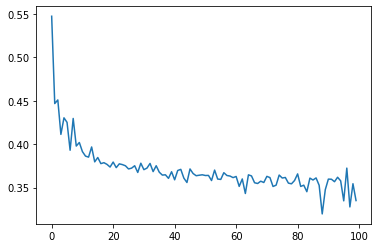

Epoch 1/100
22/22 - 3s - loss: 0.5504 - accuracy: 0.4896 - auc_31: 0.7441 - precision_31: 0.4832 - recall_31: 0.4467 - f1_score: 0.2089 - val_loss: 1.1789 - val_accuracy: 0.2500 - val_auc_31: 0.6950 - val_precision_31: 0.2727 - val_recall_31: 0.0395 - val_f1_score: 0.1011 - 3s/epoch - 120ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4662 - accuracy: 0.4808 - auc_31: 0.7693 - precision_31: 0.4684 - recall_31: 0.2086 - f1_score: 0.1993 - val_loss: 0.9220 - val_accuracy: 0.4474 - val_auc_31: 0.7009 - val_precision_31: 0.1818 - val_recall_31: 0.0263 - val_f1_score: 0.1652 - 468ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4037 - accuracy: 0.5311 - auc_31: 0.8169 - precision_31: 0.5678 - recall_31: 0.3343 - f1_score: 0.2469 - val_loss: 0.6296 - val_accuracy: 0.4342 - val_auc_31: 0.7080 - val_precision_31: 0.4459 - val_recall_31: 0.4342 - val_f1_score: 0.1393 - 477ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4193 - accuracy: 0.5178 - auc_31: 0.8067 - precision_31: 0.5202 - recall

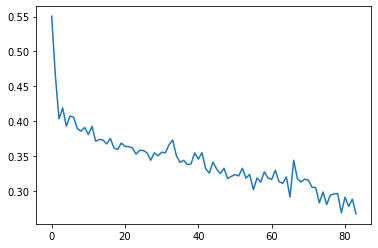

Epoch 1/100
22/22 - 2s - loss: 0.5810 - accuracy: 0.4446 - auc_32: 0.6980 - precision_32: 0.4241 - recall_32: 0.3383 - f1_score: 0.2015 - val_loss: 0.6196 - val_accuracy: 0.3733 - val_auc_32: 0.7974 - val_precision_32: 0.3733 - val_recall_32: 0.3733 - val_f1_score: 0.1087 - 2s/epoch - 107ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4470 - accuracy: 0.4786 - auc_32: 0.7826 - precision_32: 0.5121 - recall_32: 0.3752 - f1_score: 0.2068 - val_loss: 0.5152 - val_accuracy: 0.5467 - val_auc_32: 0.8453 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.1426 - 467ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4871 - accuracy: 0.4668 - auc_32: 0.7472 - precision_32: 0.4640 - recall_32: 0.1521 - f1_score: 0.2162 - val_loss: 0.4106 - val_accuracy: 0.5467 - val_auc_32: 0.8476 - val_precision_32: 0.5467 - val_recall_32: 0.5467 - val_f1_score: 0.1414 - 469ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4408 - accuracy: 0.4934 - auc_32: 0.7871 - precision_32: 0.5214 

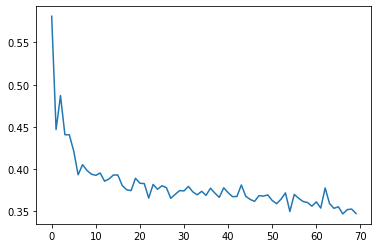

Epoch 1/100
22/22 - 2s - loss: 0.5612 - accuracy: 0.4742 - auc_33: 0.7079 - precision_33: 0.3934 - recall_33: 0.2999 - f1_score: 0.1642 - val_loss: 0.5122 - val_accuracy: 0.5067 - val_auc_33: 0.7657 - val_precision_33: 0.6667 - val_recall_33: 0.0267 - val_f1_score: 0.1494 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4680 - accuracy: 0.5096 - auc_33: 0.7620 - precision_33: 0.4915 - recall_33: 0.2999 - f1_score: 0.2014 - val_loss: 0.4616 - val_accuracy: 0.5067 - val_auc_33: 0.8210 - val_precision_33: 1.0000 - val_recall_33: 0.0133 - val_f1_score: 0.1845 - 478ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4399 - accuracy: 0.5126 - auc_33: 0.7916 - precision_33: 0.5382 - recall_33: 0.4269 - f1_score: 0.2162 - val_loss: 0.4008 - val_accuracy: 0.5067 - val_auc_33: 0.8178 - val_precision_33: 0.5067 - val_recall_33: 0.5067 - val_f1_score: 0.1845 - 466ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4353 - accuracy: 0.5155 - auc_33: 0.7935 - precision_33: 0.5263 - recall

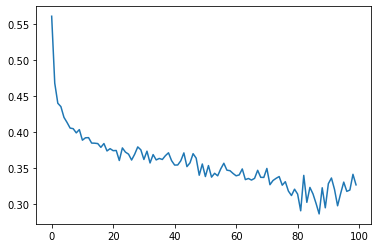

Epoch 1/100
22/22 - 2s - loss: 0.5295 - accuracy: 0.4092 - auc_34: 0.7215 - precision_34: 0.4286 - recall_34: 0.2526 - f1_score: 0.2194 - val_loss: 0.6484 - val_accuracy: 0.5733 - val_auc_34: 0.8068 - val_precision_34: 0.3333 - val_recall_34: 0.0133 - val_f1_score: 0.1659 - 2s/epoch - 105ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4616 - accuracy: 0.5022 - auc_34: 0.7688 - precision_34: 0.5200 - recall_34: 0.2688 - f1_score: 0.2046 - val_loss: 0.6083 - val_accuracy: 0.5467 - val_auc_34: 0.7923 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1414 - 467ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4479 - accuracy: 0.5273 - auc_34: 0.7906 - precision_34: 0.5288 - recall_34: 0.2984 - f1_score: 0.2227 - val_loss: 0.4711 - val_accuracy: 0.2533 - val_auc_34: 0.7423 - val_precision_34: 1.0000 - val_recall_34: 0.0133 - val_f1_score: 0.0874 - 466ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4317 - accuracy: 0.4993 - auc_34: 0.7934 - precision_34: 0.5159 

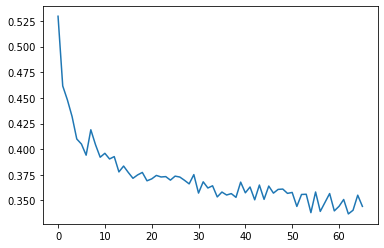

Epoch 1/100
22/22 - 2s - loss: 0.5394 - accuracy: 0.4298 - auc_35: 0.7079 - precision_35: 0.3970 - recall_35: 0.2703 - f1_score: 0.1916 - val_loss: 0.6082 - val_accuracy: 0.5067 - val_auc_35: 0.7984 - val_precision_35: 0.4737 - val_recall_35: 0.3600 - val_f1_score: 0.1345 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4575 - accuracy: 0.5111 - auc_35: 0.7888 - precision_35: 0.5271 - recall_35: 0.3309 - f1_score: 0.2170 - val_loss: 0.4732 - val_accuracy: 0.5067 - val_auc_35: 0.8169 - val_precision_35: 0.5195 - val_recall_35: 0.5333 - val_f1_score: 0.1345 - 473ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4463 - accuracy: 0.5199 - auc_35: 0.7827 - precision_35: 0.5204 - recall_35: 0.4136 - f1_score: 0.1872 - val_loss: 0.4594 - val_accuracy: 0.5333 - val_auc_35: 0.8048 - val_precision_35: 0.5195 - val_recall_35: 0.5333 - val_f1_score: 0.2512 - 457ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4372 - accuracy: 0.5155 - auc_35: 0.7925 - precision_35: 0.5333 - recall

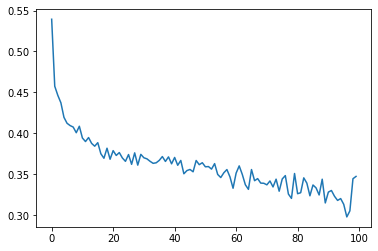

Epoch 1/100
22/22 - 2s - loss: 0.5260 - accuracy: 0.4431 - auc_36: 0.7331 - precision_36: 0.4341 - recall_36: 0.3944 - f1_score: 0.2084 - val_loss: 0.6052 - val_accuracy: 0.5600 - val_auc_36: 0.8410 - val_precision_36: 0.5600 - val_recall_36: 0.5600 - val_f1_score: 0.2105 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4810 - accuracy: 0.4771 - auc_36: 0.7581 - precision_36: 0.5306 - recall_36: 0.2688 - f1_score: 0.2103 - val_loss: 0.6172 - val_accuracy: 0.5467 - val_auc_36: 0.8343 - val_precision_36: 0.5467 - val_recall_36: 0.5467 - val_f1_score: 0.1414 - 451ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4339 - accuracy: 0.5273 - auc_36: 0.7903 - precision_36: 0.5273 - recall_36: 0.2422 - f1_score: 0.2089 - val_loss: 0.5715 - val_accuracy: 0.3200 - val_auc_36: 0.7742 - val_precision_36: 0.3243 - val_recall_36: 0.3200 - val_f1_score: 0.0990 - 460ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4202 - accuracy: 0.5244 - auc_36: 0.8004 - precision_36: 0.5390 - recall

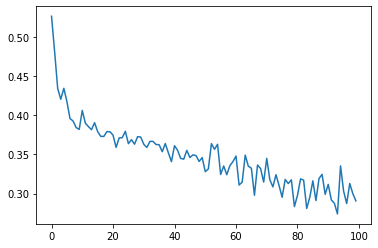

Epoch 1/100
22/22 - 2s - loss: 0.5361 - accuracy: 0.4609 - auc_37: 0.7224 - precision_37: 0.4549 - recall_37: 0.3501 - f1_score: 0.2000 - val_loss: 0.5271 - val_accuracy: 0.5200 - val_auc_37: 0.8029 - val_precision_37: 0.5270 - val_recall_37: 0.5200 - val_f1_score: 0.1368 - 2s/epoch - 108ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4490 - accuracy: 0.5244 - auc_37: 0.7923 - precision_37: 0.5272 - recall_37: 0.3294 - f1_score: 0.2260 - val_loss: 0.4702 - val_accuracy: 0.5200 - val_auc_37: 0.8034 - val_precision_37: 0.5200 - val_recall_37: 0.5200 - val_f1_score: 0.1368 - 470ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4269 - accuracy: 0.4963 - auc_37: 0.7995 - precision_37: 0.5551 - recall_37: 0.3648 - f1_score: 0.2244 - val_loss: 0.4589 - val_accuracy: 0.5200 - val_auc_37: 0.8055 - val_precision_37: 0.5200 - val_recall_37: 0.5200 - val_f1_score: 0.1368 - 454ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4048 - accuracy: 0.5303 - auc_37: 0.8102 - precision_37: 0.5325 - recall

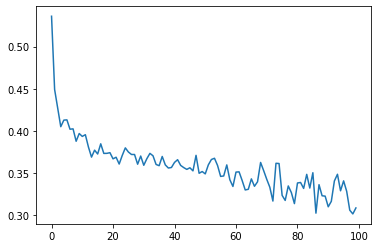

Epoch 1/100
22/22 - 3s - loss: 0.5357 - accuracy: 0.4579 - auc_38: 0.7220 - precision_38: 0.4674 - recall_38: 0.3279 - f1_score: 0.2031 - val_loss: 0.7023 - val_accuracy: 0.4533 - val_auc_38: 0.7850 - val_precision_38: 0.4533 - val_recall_38: 0.4533 - val_f1_score: 0.1271 - 3s/epoch - 118ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4568 - accuracy: 0.5199 - auc_38: 0.7824 - precision_38: 0.5603 - recall_38: 0.3294 - f1_score: 0.1794 - val_loss: 0.4016 - val_accuracy: 0.5067 - val_auc_38: 0.8462 - val_precision_38: 0.5000 - val_recall_38: 0.0933 - val_f1_score: 0.2895 - 475ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4169 - accuracy: 0.5258 - auc_38: 0.8046 - precision_38: 0.5428 - recall_38: 0.3279 - f1_score: 0.2038 - val_loss: 0.4419 - val_accuracy: 0.4000 - val_auc_38: 0.7978 - val_precision_38: 0.4000 - val_recall_38: 0.4000 - val_f1_score: 0.1331 - 466ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4362 - accuracy: 0.5318 - auc_38: 0.7899 - precision_38: 0.5383 - recall

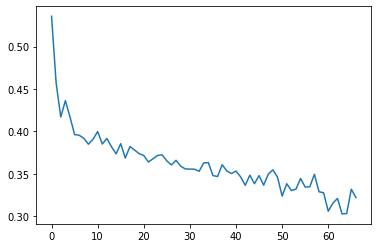

Epoch 1/100
22/22 - 2s - loss: 0.5110 - accuracy: 0.4505 - auc_39: 0.7447 - precision_39: 0.4489 - recall_39: 0.2792 - f1_score: 0.2039 - val_loss: 0.4647 - val_accuracy: 0.5867 - val_auc_39: 0.8279 - val_precision_39: 0.5867 - val_recall_39: 0.5867 - val_f1_score: 0.1479 - 2s/epoch - 105ms/step
Epoch 2/100
22/22 - 0s - loss: 0.4644 - accuracy: 0.4948 - auc_39: 0.7698 - precision_39: 0.4939 - recall_39: 0.2999 - f1_score: 0.2175 - val_loss: 0.5083 - val_accuracy: 0.5867 - val_auc_39: 0.7467 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.1479 - 444ms/epoch - 20ms/step
Epoch 3/100
22/22 - 0s - loss: 0.4472 - accuracy: 0.4860 - auc_39: 0.7721 - precision_39: 0.5118 - recall_39: 0.3530 - f1_score: 0.1944 - val_loss: 0.4088 - val_accuracy: 0.5867 - val_auc_39: 0.8257 - val_precision_39: 0.5867 - val_recall_39: 0.5867 - val_f1_score: 0.1479 - 477ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 0.4381 - accuracy: 0.5066 - auc_39: 0.7891 - precision_39: 0.5489 

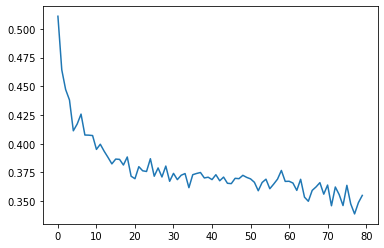

In [31]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_face_model = RCNN(n_features, None, n_length, n_outputs, multiclass=True)
    history = rcnn_area_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_face_model.save(model_path / 'face_area_rcnn.h5')

#### Training performance

In [32]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.6037368953227997,
 'ROC/AUC': 0.8745831191539765,
 'Precision': 0.6439756631851197,
 'Recall': 0.4676505267620087,
 'F1-score': 0.3682586133480072}

#### Validation performance

In [33]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.5214561432600021,
 'ROC/AUC': 0.8126980423927307,
 'Precision': 0.5289424508810043,
 'Recall': 0.3681052677333355,
 'F1-score': 0.18131935894489287}

#### Predictions and performance on test set

In [34]:
rcnn_area_face_model = load_model(model_path / 'face_area_rcnn.h5')
y_pred = rcnn_area_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 8ms/step - loss: 0.5841 - accuracy: 0.1343 - auc_36: 0.6168 - precision_36: 0.2727 - recall_36: 0.0112 - f1_score: 0.0583
Accuracy: 13.43% 
ROC/AUC: 0.62 
Precision: 0.27 
Recall: 0.01 
F1 score: 0.06


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

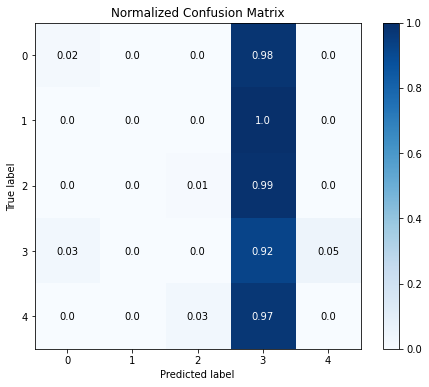

In [35]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

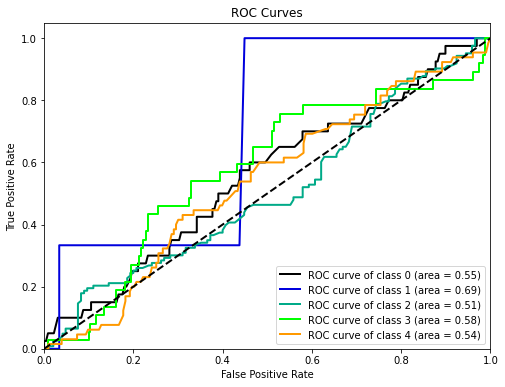

In [36]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

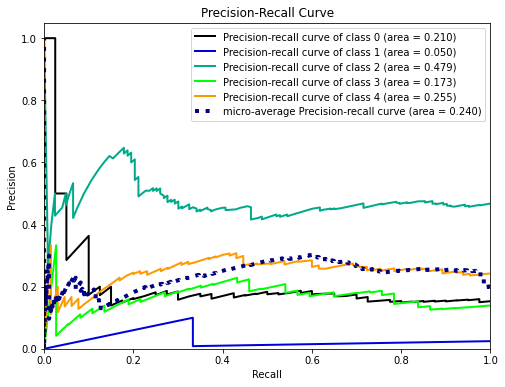

In [37]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

## 3. Multimodal Early Fusion

In [75]:
X_train, X_test, y_train, y_test = load_fusioned_dataset()
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 60) (752, 5)
(268, 1, 350, 60) (268, 5)


### 3.1 CNN + BiLSTM

Epoch 1/100
22/22 - 6s - loss: 2.0004 - accuracy: 0.3609 - auc_83: 0.6983 - precision_83: 0.2432 - recall_83: 0.0399 - f1_score: 0.2317 - val_loss: 1.2833 - val_accuracy: 0.5000 - val_auc_83: 0.7962 - val_precision_83: 0.0000e+00 - val_recall_83: 0.0000e+00 - val_f1_score: 0.2163 - 6s/epoch - 264ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3295 - accuracy: 0.4127 - auc_83: 0.7470 - precision_83: 0.5455 - recall_83: 0.1065 - f1_score: 0.2959 - val_loss: 1.3868 - val_accuracy: 0.2763 - val_auc_83: 0.7360 - val_precision_83: 0.3056 - val_recall_83: 0.1447 - val_f1_score: 0.1413 - 1s/epoch - 58ms/step
Epoch 3/100
22/22 - 1s - loss: 1.1806 - accuracy: 0.4482 - auc_83: 0.7776 - precision_83: 0.5408 - recall_83: 0.1864 - f1_score: 0.3419 - val_loss: 1.3522 - val_accuracy: 0.3684 - val_auc_83: 0.7511 - val_precision_83: 0.3902 - val_recall_83: 0.2105 - val_f1_score: 0.1949 - 1s/epoch - 58ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9789 - accuracy: 0.4926 - auc_83: 0.8249 - precision_83: 0.6071 - reca

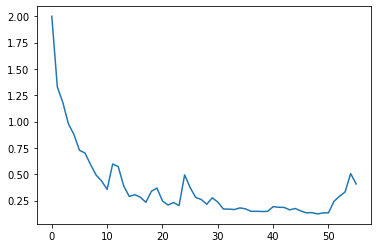

Epoch 1/100
22/22 - 6s - loss: 1.9685 - accuracy: 0.3136 - auc_84: 0.6820 - precision_84: 0.3100 - recall_84: 0.0459 - f1_score: 0.2232 - val_loss: 1.5185 - val_accuracy: 0.2500 - val_auc_84: 0.6719 - val_precision_84: 0.5000 - val_recall_84: 0.0132 - val_f1_score: 0.1346 - 6s/epoch - 252ms/step
Epoch 2/100
22/22 - 2s - loss: 1.3414 - accuracy: 0.3876 - auc_84: 0.7457 - precision_84: 0.5506 - recall_84: 0.0725 - f1_score: 0.2932 - val_loss: 1.3842 - val_accuracy: 0.4474 - val_auc_84: 0.7330 - val_precision_84: 0.4000 - val_recall_84: 0.0263 - val_f1_score: 0.2484 - 2s/epoch - 69ms/step
Epoch 3/100
22/22 - 2s - loss: 1.1140 - accuracy: 0.4882 - auc_84: 0.8066 - precision_84: 0.6667 - recall_84: 0.1923 - f1_score: 0.3567 - val_loss: 1.3764 - val_accuracy: 0.3947 - val_auc_84: 0.7284 - val_precision_84: 0.4118 - val_recall_84: 0.0921 - val_f1_score: 0.2301 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0453 - accuracy: 0.5340 - auc_84: 0.8349 - precision_84: 0.7009 - recall_84: 0

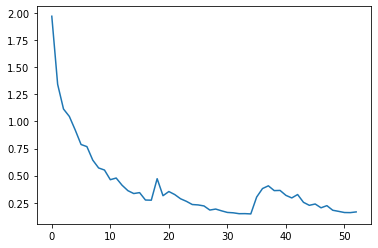

Epoch 1/100
22/22 - 6s - loss: 1.9122 - accuracy: 0.3043 - auc_85: 0.6851 - precision_85: 0.3025 - recall_85: 0.0532 - f1_score: 0.2075 - val_loss: 1.7105 - val_accuracy: 0.0800 - val_auc_85: 0.4385 - val_precision_85: 0.0000e+00 - val_recall_85: 0.0000e+00 - val_f1_score: 0.0552 - 6s/epoch - 250ms/step
Epoch 2/100
22/22 - 2s - loss: 1.3964 - accuracy: 0.4077 - auc_85: 0.7366 - precision_85: 0.7083 - recall_85: 0.1004 - f1_score: 0.2943 - val_loss: 1.5047 - val_accuracy: 0.2000 - val_auc_85: 0.6783 - val_precision_85: 0.4286 - val_recall_85: 0.0400 - val_f1_score: 0.0962 - 2s/epoch - 69ms/step
Epoch 3/100
22/22 - 2s - loss: 1.1791 - accuracy: 0.4446 - auc_85: 0.7694 - precision_85: 0.6327 - recall_85: 0.1832 - f1_score: 0.3386 - val_loss: 1.4444 - val_accuracy: 0.3733 - val_auc_85: 0.6794 - val_precision_85: 0.3529 - val_recall_85: 0.0800 - val_f1_score: 0.1869 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 2s - loss: 1.0313 - accuracy: 0.5096 - auc_85: 0.8188 - precision_85: 0.6206 - reca

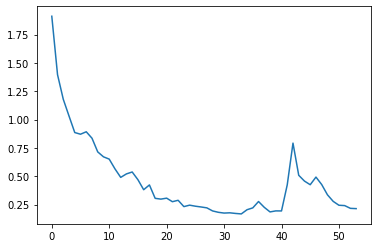

Epoch 1/100
22/22 - 6s - loss: 1.9646 - accuracy: 0.3456 - auc_86: 0.6645 - precision_86: 0.4000 - recall_86: 0.0561 - f1_score: 0.2403 - val_loss: 1.4363 - val_accuracy: 0.4000 - val_auc_86: 0.6923 - val_precision_86: 0.8000 - val_recall_86: 0.1600 - val_f1_score: 0.1819 - 6s/epoch - 254ms/step
Epoch 2/100
22/22 - 2s - loss: 1.3202 - accuracy: 0.3973 - auc_86: 0.7217 - precision_86: 0.5152 - recall_86: 0.0753 - f1_score: 0.2876 - val_loss: 1.2336 - val_accuracy: 0.4267 - val_auc_86: 0.7922 - val_precision_86: 0.5000 - val_recall_86: 0.2000 - val_f1_score: 0.2093 - 2s/epoch - 70ms/step
Epoch 3/100
22/22 - 1s - loss: 1.1931 - accuracy: 0.4549 - auc_86: 0.7822 - precision_86: 0.5731 - recall_86: 0.2201 - f1_score: 0.3449 - val_loss: 1.8323 - val_accuracy: 0.2000 - val_auc_86: 0.6514 - val_precision_86: 0.1321 - val_recall_86: 0.0933 - val_f1_score: 0.1083 - 1s/epoch - 60ms/step
Epoch 4/100
22/22 - 2s - loss: 1.3339 - accuracy: 0.4535 - auc_86: 0.7660 - precision_86: 0.4960 - recall_86: 0

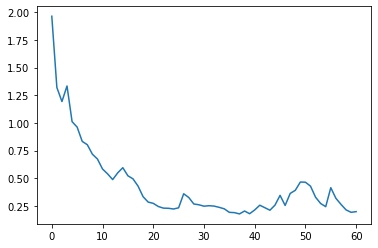

Epoch 1/100
22/22 - 6s - loss: 1.7747 - accuracy: 0.3427 - auc_87: 0.6817 - precision_87: 0.4127 - recall_87: 0.0768 - f1_score: 0.2249 - val_loss: 2.0132 - val_accuracy: 0.0667 - val_auc_87: 0.2917 - val_precision_87: 0.0000e+00 - val_recall_87: 0.0000e+00 - val_f1_score: 0.0253 - 6s/epoch - 257ms/step
Epoch 2/100
22/22 - 2s - loss: 1.3132 - accuracy: 0.4136 - auc_87: 0.7338 - precision_87: 0.6667 - recall_87: 0.0798 - f1_score: 0.3103 - val_loss: 1.6153 - val_accuracy: 0.0933 - val_auc_87: 0.6244 - val_precision_87: 0.1111 - val_recall_87: 0.0400 - val_f1_score: 0.0437 - 2s/epoch - 70ms/step
Epoch 3/100
22/22 - 1s - loss: 1.1210 - accuracy: 0.4535 - auc_87: 0.7979 - precision_87: 0.5915 - recall_87: 0.1861 - f1_score: 0.3437 - val_loss: 1.6574 - val_accuracy: 0.2267 - val_auc_87: 0.6158 - val_precision_87: 0.3000 - val_recall_87: 0.0800 - val_f1_score: 0.1398 - 1s/epoch - 60ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0240 - accuracy: 0.5185 - auc_87: 0.8215 - precision_87: 0.6154 - reca

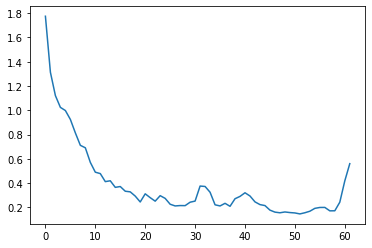

Epoch 1/100
22/22 - 6s - loss: 1.6647 - accuracy: 0.3368 - auc_88: 0.6755 - precision_88: 0.2410 - recall_88: 0.0295 - f1_score: 0.2233 - val_loss: 1.3646 - val_accuracy: 0.4267 - val_auc_88: 0.7474 - val_precision_88: 0.0000e+00 - val_recall_88: 0.0000e+00 - val_f1_score: 0.1905 - 6s/epoch - 251ms/step
Epoch 2/100
22/22 - 2s - loss: 1.2309 - accuracy: 0.4136 - auc_88: 0.7517 - precision_88: 0.5000 - recall_88: 0.1315 - f1_score: 0.3096 - val_loss: 1.2065 - val_accuracy: 0.5067 - val_auc_88: 0.8073 - val_precision_88: 0.6875 - val_recall_88: 0.1467 - val_f1_score: 0.3130 - 2s/epoch - 69ms/step
Epoch 3/100
22/22 - 1s - loss: 1.1162 - accuracy: 0.5007 - auc_88: 0.7952 - precision_88: 0.5627 - recall_88: 0.2186 - f1_score: 0.3837 - val_loss: 1.4344 - val_accuracy: 0.3333 - val_auc_88: 0.7031 - val_precision_88: 0.2727 - val_recall_88: 0.0400 - val_f1_score: 0.2295 - 1s/epoch - 59ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0204 - accuracy: 0.5199 - auc_88: 0.8187 - precision_88: 0.6242 - reca

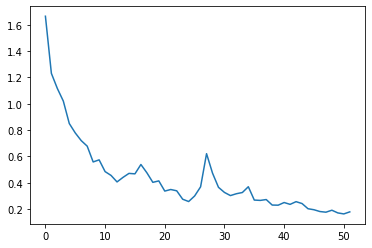

Epoch 1/100
22/22 - 6s - loss: 1.9376 - accuracy: 0.3058 - auc_89: 0.6659 - precision_89: 0.3766 - recall_89: 0.0857 - f1_score: 0.2051 - val_loss: 1.9320 - val_accuracy: 0.0133 - val_auc_89: 0.2543 - val_precision_89: 0.0000e+00 - val_recall_89: 0.0000e+00 - val_f1_score: 0.0667 - 6s/epoch - 251ms/step
Epoch 2/100
22/22 - 2s - loss: 1.4077 - accuracy: 0.3235 - auc_89: 0.6471 - precision_89: 0.5800 - recall_89: 0.0428 - f1_score: 0.2285 - val_loss: 1.1991 - val_accuracy: 0.5600 - val_auc_89: 0.8779 - val_precision_89: 0.0000e+00 - val_recall_89: 0.0000e+00 - val_f1_score: 0.3354 - 2s/epoch - 68ms/step
Epoch 3/100
22/22 - 2s - loss: 1.1498 - accuracy: 0.4520 - auc_89: 0.7777 - precision_89: 0.5229 - recall_89: 0.1182 - f1_score: 0.3325 - val_loss: 1.0925 - val_accuracy: 0.5333 - val_auc_89: 0.8501 - val_precision_89: 0.5385 - val_recall_89: 0.0933 - val_f1_score: 0.2934 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0929 - accuracy: 0.4860 - auc_89: 0.8100 - precision_89: 0.637

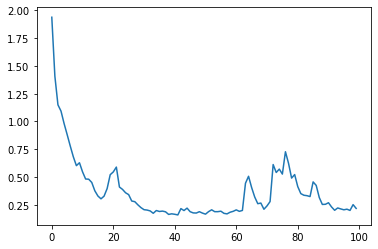

Epoch 1/100
22/22 - 6s - loss: 1.9391 - accuracy: 0.3678 - auc_90: 0.7064 - precision_90: 0.4667 - recall_90: 0.0724 - f1_score: 0.2444 - val_loss: 2.2561 - val_accuracy: 0.1067 - val_auc_90: 0.3203 - val_precision_90: 0.1667 - val_recall_90: 0.0267 - val_f1_score: 0.0681 - 6s/epoch - 251ms/step
Epoch 2/100
22/22 - 2s - loss: 1.2800 - accuracy: 0.4032 - auc_90: 0.7402 - precision_90: 0.5988 - recall_90: 0.1433 - f1_score: 0.3129 - val_loss: 1.9337 - val_accuracy: 0.1600 - val_auc_90: 0.5473 - val_precision_90: 0.0882 - val_recall_90: 0.0400 - val_f1_score: 0.1341 - 2s/epoch - 69ms/step
Epoch 3/100
22/22 - 2s - loss: 1.0115 - accuracy: 0.4919 - auc_90: 0.8111 - precision_90: 0.6157 - recall_90: 0.2201 - f1_score: 0.3937 - val_loss: 1.6015 - val_accuracy: 0.2667 - val_auc_90: 0.6583 - val_precision_90: 0.3636 - val_recall_90: 0.1600 - val_f1_score: 0.1388 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 2s - loss: 1.1629 - accuracy: 0.5140 - auc_90: 0.8238 - precision_90: 0.6221 - recall_90: 0

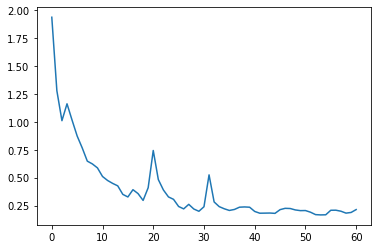

Epoch 1/100
22/22 - 6s - loss: 1.9535 - accuracy: 0.3043 - auc_91: 0.6346 - precision_91: 0.3158 - recall_91: 0.0355 - f1_score: 0.2133 - val_loss: 1.3281 - val_accuracy: 0.4400 - val_auc_91: 0.7762 - val_precision_91: 0.6000 - val_recall_91: 0.2400 - val_f1_score: 0.2046 - 6s/epoch - 252ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3300 - accuracy: 0.4106 - auc_91: 0.7321 - precision_91: 0.5850 - recall_91: 0.1270 - f1_score: 0.2902 - val_loss: 1.4591 - val_accuracy: 0.3200 - val_auc_91: 0.6661 - val_precision_91: 0.3333 - val_recall_91: 0.0667 - val_f1_score: 0.1769 - 1s/epoch - 59ms/step
Epoch 3/100
22/22 - 2s - loss: 1.2455 - accuracy: 0.4387 - auc_91: 0.7703 - precision_91: 0.5484 - recall_91: 0.1507 - f1_score: 0.3307 - val_loss: 1.2069 - val_accuracy: 0.3600 - val_auc_91: 0.8050 - val_precision_91: 0.3902 - val_recall_91: 0.2133 - val_f1_score: 0.2095 - 2s/epoch - 68ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9908 - accuracy: 0.5052 - auc_91: 0.8185 - precision_91: 0.6081 - recall_91: 0

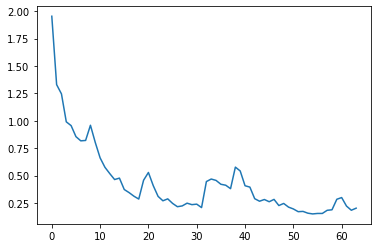

Epoch 1/100
22/22 - 6s - loss: 1.9740 - accuracy: 0.3397 - auc_92: 0.6906 - precision_92: 0.4048 - recall_92: 0.1004 - f1_score: 0.2326 - val_loss: 1.3465 - val_accuracy: 0.5867 - val_auc_92: 0.8474 - val_precision_92: 0.0000e+00 - val_recall_92: 0.0000e+00 - val_f1_score: 0.1479 - 6s/epoch - 251ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3849 - accuracy: 0.4623 - auc_92: 0.7837 - precision_92: 0.6706 - recall_92: 0.0842 - f1_score: 0.3247 - val_loss: 1.4251 - val_accuracy: 0.4667 - val_auc_92: 0.7214 - val_precision_92: 0.0000e+00 - val_recall_92: 0.0000e+00 - val_f1_score: 0.3223 - 1s/epoch - 59ms/step
Epoch 3/100
22/22 - 2s - loss: 1.1582 - accuracy: 0.4594 - auc_92: 0.7815 - precision_92: 0.6000 - recall_92: 0.1640 - f1_score: 0.3430 - val_loss: 1.3253 - val_accuracy: 0.4533 - val_auc_92: 0.7571 - val_precision_92: 0.7273 - val_recall_92: 0.1067 - val_f1_score: 0.2780 - 2s/epoch - 69ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0397 - accuracy: 0.5022 - auc_92: 0.8239 - precision_92: 0.627

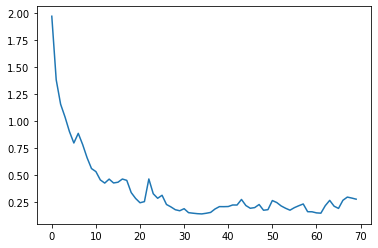

In [76]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_earlyfusion_model = CNNLSTM(n_features, None, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_earlyfusion_model.save(model_path / 'early_area_cnnlstm.h5')

#### Training performance

In [77]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.8968624591827392,
 'ROC/AUC': 0.98509481549263,
 'Precision': 0.9065157353878022,
 'Recall': 0.888734233379364,
 'F1-score': 0.7986794412136078}

#### Validation performance

In [78]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.5653684139251709,
 'ROC/AUC': 0.8072601139545441,
 'Precision': 0.5744565159082413,
 'Recall': 0.5387543886899948,
 'F1-score': 0.3554106384515762}

#### Predictions and performance on test set

In [79]:
cnnlstm_area_earlyfusion_model = load_model(model_path / 'early_area_cnnlstm.h5')
y_pred = cnnlstm_area_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_earlyfusion_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 15ms/step - loss: 2.1744 - accuracy: 0.2575 - auc_86: 0.6196 - precision_86: 0.2585 - recall_86: 0.1978 - f1_score: 0.1591
Accuracy: 25.75% 
ROC/AUC: 0.62 
Precision: 0.26 
Recall: 0.20 
F1 score: 0.16


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

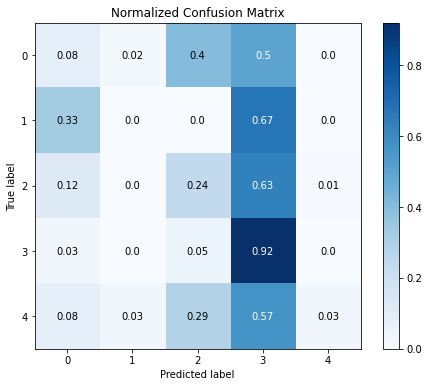

In [80]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

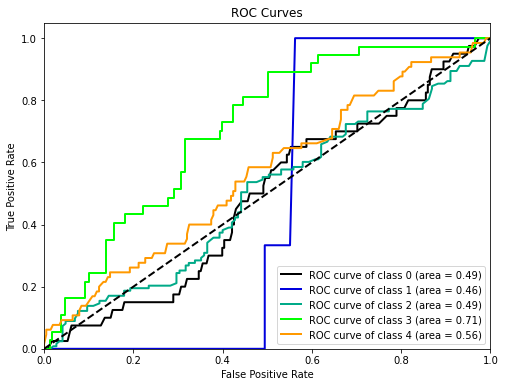

In [81]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

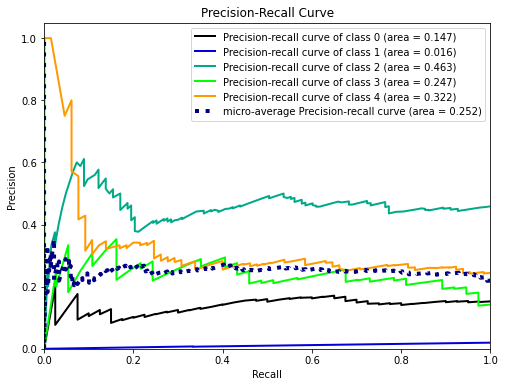

In [82]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 3.2 RCNN

Epoch 1/100
22/22 - 2s - loss: 2.0497 - accuracy: 0.2604 - auc_93: 0.5536 - precision_93: 0.2479 - recall_93: 0.0429 - f1_score: 0.1824 - val_loss: 1.6927 - val_accuracy: 0.1184 - val_auc_93: 0.4227 - val_precision_93: 0.0000e+00 - val_recall_93: 0.0000e+00 - val_f1_score: 0.0424 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 1.8690 - accuracy: 0.1538 - auc_93: 0.5089 - precision_93: 0.1667 - recall_93: 0.0325 - f1_score: 0.1288 - val_loss: 1.6051 - val_accuracy: 0.1184 - val_auc_93: 0.4778 - val_precision_93: 0.0000e+00 - val_recall_93: 0.0000e+00 - val_f1_score: 0.0424 - 470ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.7293 - accuracy: 0.1672 - auc_93: 0.5425 - precision_93: 0.4516 - recall_93: 0.0621 - f1_score: 0.1415 - val_loss: 1.6421 - val_accuracy: 0.0000e+00 - val_auc_93: 0.3606 - val_precision_93: 0.0000e+00 - val_recall_93: 0.0000e+00 - val_f1_score: 0.0000e+00 - 449ms/epoch - 20ms/step
Epoch 4/100
22/22 - 0s - loss: 1.6224 - accuracy: 0.1479 - auc_93: 0.5226

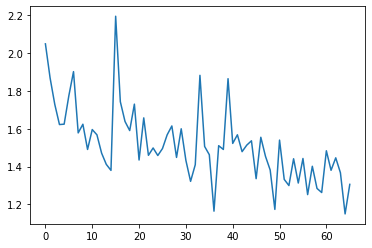

Epoch 1/100
22/22 - 2s - loss: 2.2762 - accuracy: 0.2544 - auc_94: 0.6007 - precision_94: 0.2887 - recall_94: 0.0607 - f1_score: 0.1741 - val_loss: 2.8986 - val_accuracy: 0.4474 - val_auc_94: 0.6573 - val_precision_94: 0.2857 - val_recall_94: 0.0263 - val_f1_score: 0.1500 - 2s/epoch - 105ms/step
Epoch 2/100
22/22 - 0s - loss: 2.1654 - accuracy: 0.2485 - auc_94: 0.5981 - precision_94: 0.3287 - recall_94: 0.0695 - f1_score: 0.1744 - val_loss: 7.6235 - val_accuracy: 0.0000e+00 - val_auc_94: 0.4323 - val_precision_94: 0.0000e+00 - val_recall_94: 0.0000e+00 - val_f1_score: 0.0000e+00 - 460ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 2.4734 - accuracy: 0.1879 - auc_94: 0.5771 - precision_94: 0.2427 - recall_94: 0.0858 - f1_score: 0.1617 - val_loss: 2.1812 - val_accuracy: 0.4474 - val_auc_94: 0.6709 - val_precision_94: 0.2857 - val_recall_94: 0.0263 - val_f1_score: 0.1652 - 477ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.5121 - accuracy: 0.3580 - auc_94: 0.6708 - precision_94:

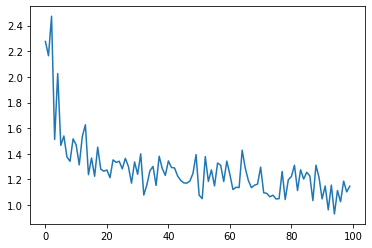

Epoch 1/100
22/22 - 2s - loss: 2.3984 - accuracy: 0.2482 - auc_95: 0.6131 - precision_95: 0.1937 - recall_95: 0.0458 - f1_score: 0.1855 - val_loss: 1.8545 - val_accuracy: 0.3733 - val_auc_95: 0.6524 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00 - val_f1_score: 0.1087 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 1.5775 - accuracy: 0.3442 - auc_95: 0.6654 - precision_95: 0.3907 - recall_95: 0.0871 - f1_score: 0.2342 - val_loss: 1.7555 - val_accuracy: 0.0267 - val_auc_95: 0.6529 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00 - val_f1_score: 0.0105 - 470ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.6611 - accuracy: 0.2304 - auc_95: 0.6162 - precision_95: 0.4417 - recall_95: 0.0783 - f1_score: 0.1802 - val_loss: 1.7670 - val_accuracy: 0.0267 - val_auc_95: 0.5526 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00 - val_f1_score: 0.0105 - 452ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.6802 - accuracy: 0.2290 - auc_95: 0.6123 - preci

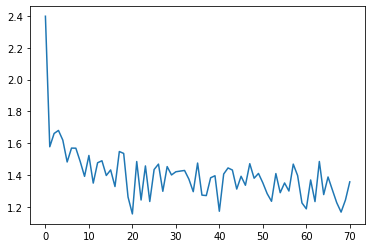

Epoch 1/100
22/22 - 2s - loss: 1.9086 - accuracy: 0.1743 - auc_96: 0.5604 - precision_96: 0.1522 - recall_96: 0.0310 - f1_score: 0.1485 - val_loss: 1.6270 - val_accuracy: 0.0933 - val_auc_96: 0.6136 - val_precision_96: 0.5000 - val_recall_96: 0.0133 - val_f1_score: 0.0871 - 2s/epoch - 107ms/step
Epoch 2/100
22/22 - 0s - loss: 1.7766 - accuracy: 0.1315 - auc_96: 0.5439 - precision_96: 0.3913 - recall_96: 0.0665 - f1_score: 0.1333 - val_loss: 1.9142 - val_accuracy: 0.0933 - val_auc_96: 0.5575 - val_precision_96: 0.5000 - val_recall_96: 0.0133 - val_f1_score: 0.0804 - 455ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.8919 - accuracy: 0.2068 - auc_96: 0.5493 - precision_96: 0.2681 - recall_96: 0.0547 - f1_score: 0.1813 - val_loss: 2.2357 - val_accuracy: 0.0000e+00 - val_auc_96: 0.5126 - val_precision_96: 0.0000e+00 - val_recall_96: 0.0000e+00 - val_f1_score: 0.0000e+00 - 451ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.9002 - accuracy: 0.2009 - auc_96: 0.6047 - precision_96:

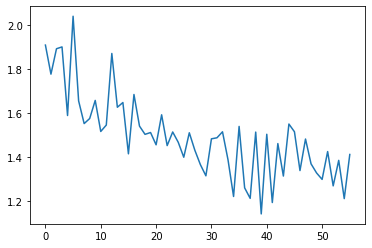

Epoch 1/100
22/22 - 2s - loss: 1.9075 - accuracy: 0.2482 - auc_97: 0.5708 - precision_97: 0.3357 - recall_97: 0.0694 - f1_score: 0.1849 - val_loss: 1.8669 - val_accuracy: 0.5467 - val_auc_97: 0.7822 - val_precision_97: 0.0000e+00 - val_recall_97: 0.0000e+00 - val_f1_score: 0.1414 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 1.9302 - accuracy: 0.2112 - auc_97: 0.6107 - precision_97: 0.4511 - recall_97: 0.0886 - f1_score: 0.1713 - val_loss: 2.1589 - val_accuracy: 0.0667 - val_auc_97: 0.5097 - val_precision_97: 0.0000e+00 - val_recall_97: 0.0000e+00 - val_f1_score: 0.0250 - 437ms/epoch - 20ms/step
Epoch 3/100
22/22 - 0s - loss: 1.6063 - accuracy: 0.2925 - auc_97: 0.6730 - precision_97: 0.3966 - recall_97: 0.0679 - f1_score: 0.2111 - val_loss: 1.7392 - val_accuracy: 0.4533 - val_auc_97: 0.7353 - val_precision_97: 0.0000e+00 - val_recall_97: 0.0000e+00 - val_f1_score: 0.1515 - 474ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.4213 - accuracy: 0.4106 - auc_97: 0.7078 - preci

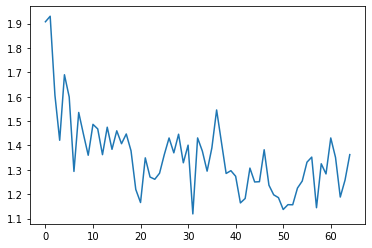

Epoch 1/100
22/22 - 3s - loss: 2.0230 - accuracy: 0.2585 - auc_98: 0.5942 - precision_98: 0.3333 - recall_98: 0.0502 - f1_score: 0.1810 - val_loss: 1.5729 - val_accuracy: 0.1333 - val_auc_98: 0.4270 - val_precision_98: 1.0000 - val_recall_98: 0.0267 - val_f1_score: 0.1538 - 3s/epoch - 126ms/step
Epoch 2/100
22/22 - 0s - loss: 1.6024 - accuracy: 0.2290 - auc_98: 0.5878 - precision_98: 0.2708 - recall_98: 0.0384 - f1_score: 0.1884 - val_loss: 1.4891 - val_accuracy: 0.3333 - val_auc_98: 0.7725 - val_precision_98: 1.0000 - val_recall_98: 0.0267 - val_f1_score: 0.2101 - 461ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 2.0990 - accuracy: 0.1625 - auc_98: 0.4697 - precision_98: 0.2410 - recall_98: 0.0295 - f1_score: 0.1340 - val_loss: 1.6088 - val_accuracy: 0.0667 - val_auc_98: 0.3462 - val_precision_98: 1.0000 - val_recall_98: 0.0267 - val_f1_score: 0.0250 - 455ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.5724 - accuracy: 0.2053 - auc_98: 0.6465 - precision_98: 0.3902 - recall

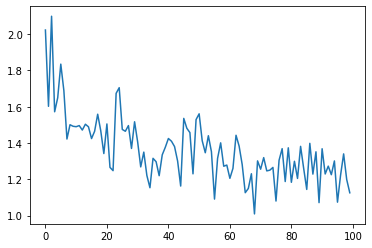

Epoch 1/100
22/22 - 2s - loss: 2.0103 - accuracy: 0.2393 - auc_99: 0.5547 - precision_99: 0.2459 - recall_99: 0.0443 - f1_score: 0.1603 - val_loss: 3.5470 - val_accuracy: 0.0800 - val_auc_99: 0.5013 - val_precision_99: 0.3333 - val_recall_99: 0.0133 - val_f1_score: 0.0828 - 2s/epoch - 109ms/step
Epoch 2/100
22/22 - 0s - loss: 1.9319 - accuracy: 0.2216 - auc_99: 0.6285 - precision_99: 0.3158 - recall_99: 0.0709 - f1_score: 0.1732 - val_loss: 2.0148 - val_accuracy: 0.0133 - val_auc_99: 0.2393 - val_precision_99: 0.3333 - val_recall_99: 0.0133 - val_f1_score: 0.0571 - 477ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.6658 - accuracy: 0.1979 - auc_99: 0.5844 - precision_99: 0.2806 - recall_99: 0.0576 - f1_score: 0.1641 - val_loss: 1.6676 - val_accuracy: 0.0800 - val_auc_99: 0.5467 - val_precision_99: 0.3333 - val_recall_99: 0.0133 - val_f1_score: 0.0920 - 469ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.7021 - accuracy: 0.1329 - auc_99: 0.5393 - precision_99: 0.2276 - recall

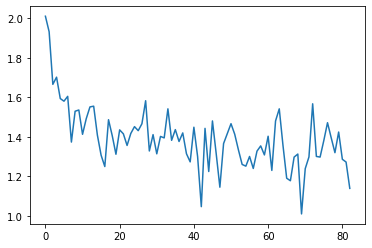

Epoch 1/100
22/22 - 2s - loss: 2.8594 - accuracy: 0.2127 - auc_100: 0.5426 - precision_100: 0.1748 - recall_100: 0.0369 - f1_score: 0.1587 - val_loss: 1.9285 - val_accuracy: 0.2667 - val_auc_100: 0.3295 - val_precision_100: 0.0000e+00 - val_recall_100: 0.0000e+00 - val_f1_score: 0.0899 - 2s/epoch - 106ms/step
Epoch 2/100
22/22 - 0s - loss: 1.7722 - accuracy: 0.1950 - auc_100: 0.5066 - precision_100: 0.3827 - recall_100: 0.0458 - f1_score: 0.1670 - val_loss: 1.8202 - val_accuracy: 0.0800 - val_auc_100: 0.3876 - val_precision_100: 0.0000e+00 - val_recall_100: 0.0000e+00 - val_f1_score: 0.0296 - 468ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.8790 - accuracy: 0.2792 - auc_100: 0.5138 - precision_100: 0.3148 - recall_100: 0.0502 - f1_score: 0.2147 - val_loss: 1.7874 - val_accuracy: 0.0000e+00 - val_auc_100: 0.5677 - val_precision_100: 0.0000e+00 - val_recall_100: 0.0000e+00 - val_f1_score: 0.0000e+00 - 465ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 2.0953 - accuracy: 0.180

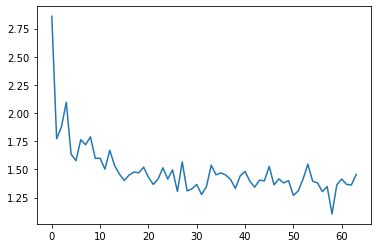

Epoch 1/100
22/22 - 2s - loss: 2.4174 - accuracy: 0.2555 - auc_101: 0.5720 - precision_101: 0.1589 - recall_101: 0.0355 - f1_score: 0.1501 - val_loss: 2.2758 - val_accuracy: 0.1467 - val_auc_101: 0.5138 - val_precision_101: 0.3333 - val_recall_101: 0.0267 - val_f1_score: 0.1262 - 2s/epoch - 108ms/step
Epoch 2/100
22/22 - 0s - loss: 1.9151 - accuracy: 0.1477 - auc_101: 0.5548 - precision_101: 0.2637 - recall_101: 0.0355 - f1_score: 0.1193 - val_loss: 1.7071 - val_accuracy: 0.0800 - val_auc_101: 0.3144 - val_precision_101: 0.6667 - val_recall_101: 0.0533 - val_f1_score: 0.0430 - 484ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.7320 - accuracy: 0.1536 - auc_101: 0.5203 - precision_101: 0.2479 - recall_101: 0.0428 - f1_score: 0.1431 - val_loss: 2.0278 - val_accuracy: 0.4533 - val_auc_101: 0.5977 - val_precision_101: 0.3333 - val_recall_101: 0.0267 - val_f1_score: 0.2043 - 458ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 2.2374 - accuracy: 0.1920 - auc_101: 0.5823 - precision_

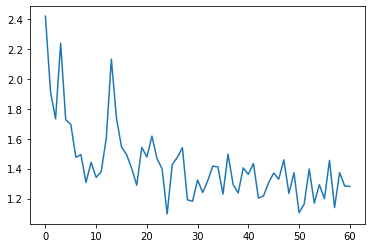

Epoch 1/100
22/22 - 2s - loss: 2.1367 - accuracy: 0.1241 - auc_102: 0.4815 - precision_102: 0.2045 - recall_102: 0.0266 - f1_score: 0.1073 - val_loss: 1.5742 - val_accuracy: 0.2400 - val_auc_102: 0.7341 - val_precision_102: 0.0000e+00 - val_recall_102: 0.0000e+00 - val_f1_score: 0.0774 - 2s/epoch - 109ms/step
Epoch 2/100
22/22 - 0s - loss: 1.7738 - accuracy: 0.2171 - auc_102: 0.6226 - precision_102: 0.3051 - recall_102: 0.0266 - f1_score: 0.1607 - val_loss: 1.6277 - val_accuracy: 0.0800 - val_auc_102: 0.4848 - val_precision_102: 0.0000e+00 - val_recall_102: 0.0000e+00 - val_f1_score: 0.0296 - 478ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.6645 - accuracy: 0.2112 - auc_102: 0.6516 - precision_102: 0.3289 - recall_102: 0.0369 - f1_score: 0.1701 - val_loss: 1.5796 - val_accuracy: 0.2400 - val_auc_102: 0.7067 - val_precision_102: 0.0000e+00 - val_recall_102: 0.0000e+00 - val_f1_score: 0.0774 - 473ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.6900 - accuracy: 0.3087 - auc_

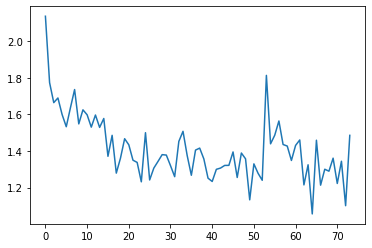

In [83]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_earlyfusion_model = RCNN(n_features, None, n_length, n_outputs, multiclass=True)
    history = rcnn_area_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_earlyfusion_model.save(model_path / 'early_area_rcnn.h5')

#### Training performance

In [84]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.35166545808315275,
 'ROC/AUC': 0.7242898762226104,
 'Precision': 0.6792827844619751,
 'Recall': 0.1946216769516468,
 'F1-score': 0.3037602648139}

#### Validation performance

In [85]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.16529824938625098,
 'ROC/AUC': 0.5257739305496216,
 'Precision': 0.26190476417541503,
 'Recall': 0.010631579160690307,
 'F1-score': 0.08587720301002263}

#### Predictions and performance on test set

In [86]:
rcnn_area_earlyfusion_model = load_model(model_path / 'early_area_rcnn.h5')
y_pred = rcnn_area_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_earlyfusion_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 8ms/step - loss: 1.6314 - accuracy: 0.1343 - auc_98: 0.5793 - precision_98: 0.2000 - recall_98: 0.0037 - f1_score: 0.0583   
Accuracy: 13.43% 
ROC/AUC: 0.58 
Precision: 0.20 
Recall: 0.00 
F1 score: 0.06


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

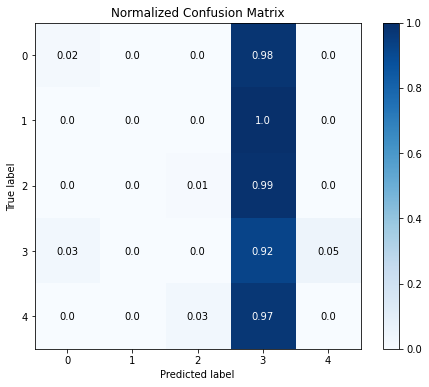

In [87]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

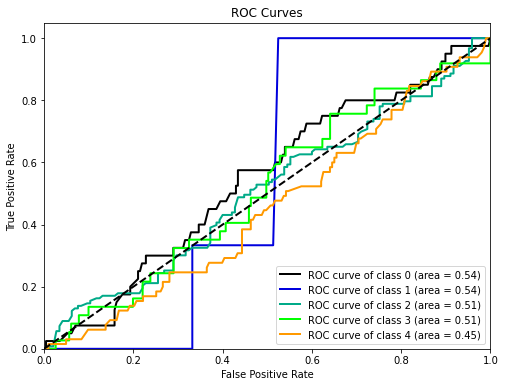

In [88]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

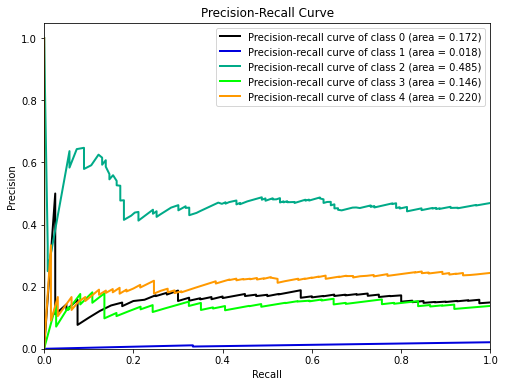

In [90]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 4. Multimodal Late Fusion

In [91]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(752, 1, 350, 35) (752, 5)
(268, 1, 350, 35) (268, 5)


In [92]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(752, 1, 350, 25) (752, 5)
(268, 1, 350, 25) (268, 5)


In [93]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
22/22 - 6s - loss: 1.7818 - accuracy: 0.3062 - auc_103: 0.6331 - precision_103: 0.2551 - recall_103: 0.0370 - f1_score: 0.2216 - val_loss: 1.5581 - val_accuracy: 0.2500 - val_auc_103: 0.6200 - val_precision_103: 0.0000e+00 - val_recall_103: 0.0000e+00 - val_f1_score: 0.1118 - 6s/epoch - 286ms/step
Epoch 2/100
22/22 - 1s - loss: 1.2656 - accuracy: 0.4482 - auc_103: 0.7612 - precision_103: 0.5271 - recall_103: 0.1006 - f1_score: 0.3430 - val_loss: 1.4351 - val_accuracy: 0.4342 - val_auc_103: 0.7352 - val_precision_103: 0.0000e+00 - val_recall_103: 0.0000e+00 - val_f1_score: 0.2073 - 1s/epoch - 56ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0080 - accuracy: 0.5370 - auc_103: 0.8337 - precision_103: 0.6500 - recall_103: 0.2692 - f1_score: 0.4180 - val_loss: 1.5866 - val_accuracy: 0.3158 - val_auc_103: 0.6173 - val_precision_103: 0.0000e+00 - val_recall_103: 0.0000e+00 - val_f1_score: 0.1896 - 1s/epoch - 50ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9282 - accuracy: 0.5666 - auc_103: 0

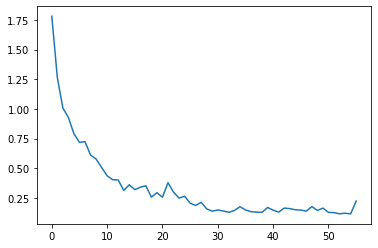

Epoch 1/100
22/22 - 7s - loss: 1.8224 - accuracy: 0.2189 - auc_104: 0.5846 - precision_104: 0.3651 - recall_104: 0.0340 - f1_score: 0.1560 - val_loss: 1.6451 - val_accuracy: 0.1447 - val_auc_104: 0.5779 - val_precision_104: 0.0000e+00 - val_recall_104: 0.0000e+00 - val_f1_score: 0.0893 - 7s/epoch - 306ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3282 - accuracy: 0.4349 - auc_104: 0.7487 - precision_104: 0.4675 - recall_104: 0.0533 - f1_score: 0.3329 - val_loss: 1.5218 - val_accuracy: 0.2763 - val_auc_104: 0.6613 - val_precision_104: 0.1667 - val_recall_104: 0.0132 - val_f1_score: 0.1399 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0038 - accuracy: 0.4985 - auc_104: 0.8185 - precision_104: 0.6603 - recall_104: 0.2041 - f1_score: 0.3837 - val_loss: 1.3718 - val_accuracy: 0.4474 - val_auc_104: 0.7364 - val_precision_104: 0.5000 - val_recall_104: 0.0263 - val_f1_score: 0.2870 - 1s/epoch - 56ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0004 - accuracy: 0.5325 - auc_104: 0.8312 - precisio

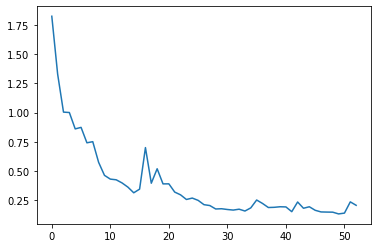

Epoch 1/100
22/22 - 6s - loss: 1.8709 - accuracy: 0.3161 - auc_105: 0.6585 - precision_105: 0.2157 - recall_105: 0.0162 - f1_score: 0.2192 - val_loss: 1.6002 - val_accuracy: 0.1733 - val_auc_105: 0.5132 - val_precision_105: 0.0000e+00 - val_recall_105: 0.0000e+00 - val_f1_score: 0.0830 - 6s/epoch - 286ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3288 - accuracy: 0.4092 - auc_105: 0.7349 - precision_105: 0.4444 - recall_105: 0.0236 - f1_score: 0.3007 - val_loss: 1.7111 - val_accuracy: 0.3333 - val_auc_105: 0.5676 - val_precision_105: 0.0000e+00 - val_recall_105: 0.0000e+00 - val_f1_score: 0.1075 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0921 - accuracy: 0.4476 - auc_105: 0.7893 - precision_105: 0.6243 - recall_105: 0.1595 - f1_score: 0.3454 - val_loss: 1.9151 - val_accuracy: 0.0400 - val_auc_105: 0.5083 - val_precision_105: 0.0500 - val_recall_105: 0.0267 - val_f1_score: 0.0156 - 1s/epoch - 51ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0481 - accuracy: 0.5037 - auc_105: 0.8132 - 

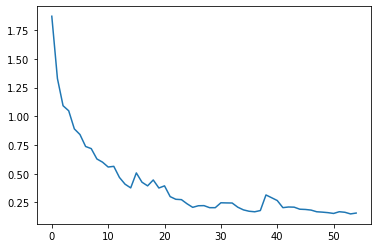

Epoch 1/100
22/22 - 7s - loss: 1.8221 - accuracy: 0.2511 - auc_106: 0.5995 - precision_106: 0.4000 - recall_106: 0.0207 - f1_score: 0.1770 - val_loss: 1.2409 - val_accuracy: 0.4933 - val_auc_106: 0.8173 - val_precision_106: 0.6250 - val_recall_106: 0.0667 - val_f1_score: 0.1333 - 7s/epoch - 307ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3070 - accuracy: 0.4697 - auc_106: 0.7641 - precision_106: 0.6460 - recall_106: 0.1078 - f1_score: 0.3340 - val_loss: 1.4125 - val_accuracy: 0.4000 - val_auc_106: 0.7412 - val_precision_106: 0.3333 - val_recall_106: 0.0133 - val_f1_score: 0.2459 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0752 - accuracy: 0.4963 - auc_106: 0.8026 - precision_106: 0.6492 - recall_106: 0.2378 - f1_score: 0.3839 - val_loss: 1.2784 - val_accuracy: 0.3867 - val_auc_106: 0.7706 - val_precision_106: 0.6667 - val_recall_106: 0.0800 - val_f1_score: 0.2731 - 1s/epoch - 50ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9603 - accuracy: 0.5155 - auc_106: 0.8300 - precision_106: 0

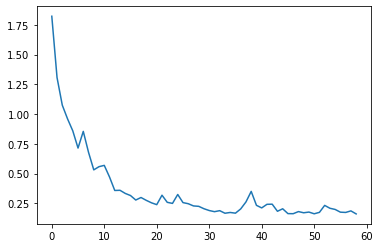

Epoch 1/100
22/22 - 6s - loss: 1.6502 - accuracy: 0.3235 - auc_107: 0.6602 - precision_107: 0.4400 - recall_107: 0.0487 - f1_score: 0.2170 - val_loss: 1.6142 - val_accuracy: 0.1600 - val_auc_107: 0.5294 - val_precision_107: 0.0000e+00 - val_recall_107: 0.0000e+00 - val_f1_score: 0.1026 - 6s/epoch - 286ms/step
Epoch 2/100
22/22 - 1s - loss: 1.1864 - accuracy: 0.4461 - auc_107: 0.7593 - precision_107: 0.5645 - recall_107: 0.1034 - f1_score: 0.3318 - val_loss: 1.7115 - val_accuracy: 0.1733 - val_auc_107: 0.5095 - val_precision_107: 0.0000e+00 - val_recall_107: 0.0000e+00 - val_f1_score: 0.0822 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0218 - accuracy: 0.5214 - auc_107: 0.8246 - precision_107: 0.7067 - recall_107: 0.2171 - f1_score: 0.4110 - val_loss: 1.8362 - val_accuracy: 0.0933 - val_auc_107: 0.4764 - val_precision_107: 0.2222 - val_recall_107: 0.0267 - val_f1_score: 0.0534 - 1s/epoch - 49ms/step
Epoch 4/100
22/22 - 1s - loss: 0.9089 - accuracy: 0.5347 - auc_107: 0.8474 - 

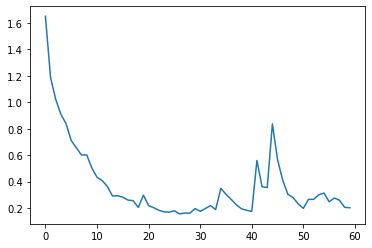

Epoch 1/100
22/22 - 7s - loss: 1.6917 - accuracy: 0.2614 - auc_108: 0.6608 - precision_108: 0.1940 - recall_108: 0.0192 - f1_score: 0.1967 - val_loss: 1.4085 - val_accuracy: 0.4800 - val_auc_108: 0.7213 - val_precision_108: 0.0000e+00 - val_recall_108: 0.0000e+00 - val_f1_score: 0.1804 - 7s/epoch - 303ms/step
Epoch 2/100
22/22 - 1s - loss: 1.2377 - accuracy: 0.4372 - auc_108: 0.7620 - precision_108: 0.5714 - recall_108: 0.0709 - f1_score: 0.3307 - val_loss: 2.4011 - val_accuracy: 0.0667 - val_auc_108: 0.5974 - val_precision_108: 0.0667 - val_recall_108: 0.0667 - val_f1_score: 0.0250 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0594 - accuracy: 0.4668 - auc_108: 0.7909 - precision_108: 0.5896 - recall_108: 0.1846 - f1_score: 0.3685 - val_loss: 1.3404 - val_accuracy: 0.5067 - val_auc_108: 0.7970 - val_precision_108: 0.5067 - val_recall_108: 0.5067 - val_f1_score: 0.1345 - 1s/epoch - 55ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1093 - accuracy: 0.5583 - auc_108: 0.8318 - precisio

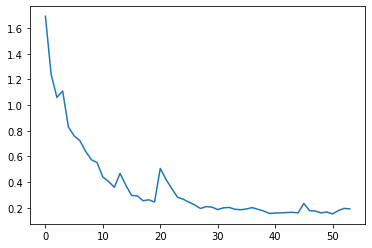

Epoch 1/100
22/22 - 6s - loss: 1.6176 - accuracy: 0.2408 - auc_109: 0.5997 - precision_109: 0.0777 - recall_109: 0.0118 - f1_score: 0.1895 - val_loss: 1.7414 - val_accuracy: 0.0533 - val_auc_109: 0.5652 - val_precision_109: 0.2308 - val_recall_109: 0.0400 - val_f1_score: 0.0203 - 6s/epoch - 287ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3949 - accuracy: 0.3309 - auc_109: 0.6863 - precision_109: 0.3143 - recall_109: 0.0650 - f1_score: 0.2653 - val_loss: 1.3132 - val_accuracy: 0.5600 - val_auc_109: 0.8441 - val_precision_109: 0.5000 - val_recall_109: 0.0133 - val_f1_score: 0.3199 - 1s/epoch - 54ms/step
Epoch 3/100
22/22 - 1s - loss: 1.2435 - accuracy: 0.4490 - auc_109: 0.7873 - precision_109: 0.6107 - recall_109: 0.1182 - f1_score: 0.3405 - val_loss: 1.3985 - val_accuracy: 0.3733 - val_auc_109: 0.7372 - val_precision_109: 0.4545 - val_recall_109: 0.0667 - val_f1_score: 0.2099 - 1s/epoch - 49ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0159 - accuracy: 0.5066 - auc_109: 0.8116 - precision_109: 0

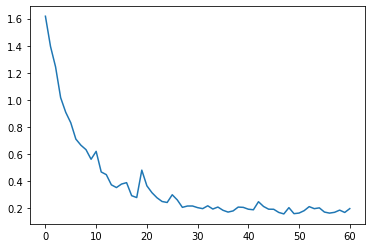

Epoch 1/100
22/22 - 7s - loss: 1.7538 - accuracy: 0.2393 - auc_110: 0.5820 - precision_110: 0.1964 - recall_110: 0.0162 - f1_score: 0.1801 - val_loss: 1.4409 - val_accuracy: 0.4000 - val_auc_110: 0.7249 - val_precision_110: 0.0000e+00 - val_recall_110: 0.0000e+00 - val_f1_score: 0.2032 - 7s/epoch - 304ms/step
Epoch 2/100
22/22 - 1s - loss: 1.3895 - accuracy: 0.4874 - auc_110: 0.7797 - precision_110: 0.6316 - recall_110: 0.1064 - f1_score: 0.3440 - val_loss: 1.4386 - val_accuracy: 0.3867 - val_auc_110: 0.7169 - val_precision_110: 1.0000 - val_recall_110: 0.0400 - val_f1_score: 0.1602 - 1s/epoch - 56ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0823 - accuracy: 0.4934 - auc_110: 0.7997 - precision_110: 0.6250 - recall_110: 0.1773 - f1_score: 0.3801 - val_loss: 1.5471 - val_accuracy: 0.1467 - val_auc_110: 0.6437 - val_precision_110: 0.0645 - val_recall_110: 0.0267 - val_f1_score: 0.0759 - 1s/epoch - 49ms/step
Epoch 4/100
22/22 - 1s - loss: 1.0322 - accuracy: 0.5598 - auc_110: 0.8415 - precisio

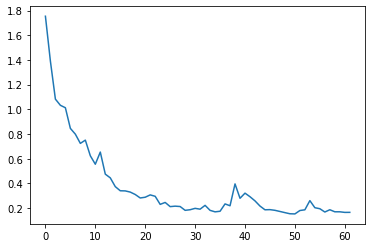

Epoch 1/100
22/22 - 7s - loss: 1.8232 - accuracy: 0.2925 - auc_111: 0.6210 - precision_111: 0.4368 - recall_111: 0.0561 - f1_score: 0.2137 - val_loss: 1.4674 - val_accuracy: 0.4667 - val_auc_111: 0.7459 - val_precision_111: 0.0000e+00 - val_recall_111: 0.0000e+00 - val_f1_score: 0.2257 - 7s/epoch - 297ms/step
Epoch 2/100
22/22 - 1s - loss: 1.4441 - accuracy: 0.3811 - auc_111: 0.7368 - precision_111: 0.4308 - recall_111: 0.0414 - f1_score: 0.2822 - val_loss: 1.5641 - val_accuracy: 0.1867 - val_auc_111: 0.5805 - val_precision_111: 0.0000e+00 - val_recall_111: 0.0000e+00 - val_f1_score: 0.1162 - 1s/epoch - 50ms/step
Epoch 3/100
22/22 - 1s - loss: 1.1754 - accuracy: 0.3870 - auc_111: 0.7302 - precision_111: 0.4776 - recall_111: 0.1418 - f1_score: 0.3172 - val_loss: 1.4970 - val_accuracy: 0.2533 - val_auc_111: 0.6716 - val_precision_111: 0.1429 - val_recall_111: 0.0533 - val_f1_score: 0.1608 - 1s/epoch - 49ms/step
Epoch 4/100
22/22 - 1s - loss: 1.1096 - accuracy: 0.4579 - auc_111: 0.7867 - 

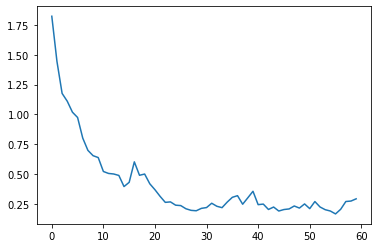

Epoch 1/100
22/22 - 6s - loss: 1.7248 - accuracy: 0.3368 - auc_112: 0.6590 - precision_112: 0.2807 - recall_112: 0.0236 - f1_score: 0.2427 - val_loss: 1.5739 - val_accuracy: 0.2800 - val_auc_112: 0.5969 - val_precision_112: 0.0000e+00 - val_recall_112: 0.0000e+00 - val_f1_score: 0.1801 - 6s/epoch - 283ms/step
Epoch 2/100
22/22 - 1s - loss: 1.2201 - accuracy: 0.4372 - auc_112: 0.7616 - precision_112: 0.6535 - recall_112: 0.0975 - f1_score: 0.3291 - val_loss: 1.9272 - val_accuracy: 0.0800 - val_auc_112: 0.5512 - val_precision_112: 0.1091 - val_recall_112: 0.0800 - val_f1_score: 0.0296 - 1s/epoch - 51ms/step
Epoch 3/100
22/22 - 1s - loss: 1.0460 - accuracy: 0.4579 - auc_112: 0.7917 - precision_112: 0.6429 - recall_112: 0.1994 - f1_score: 0.3763 - val_loss: 1.5813 - val_accuracy: 0.2533 - val_auc_112: 0.6704 - val_precision_112: 0.2558 - val_recall_112: 0.1467 - val_f1_score: 0.0887 - 1s/epoch - 48ms/step
Epoch 4/100
22/22 - 1s - loss: 0.8718 - accuracy: 0.5569 - auc_112: 0.8523 - precisio

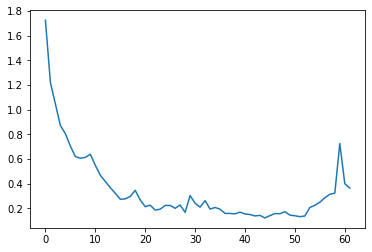

In [94]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_latefusion_model = CNNLSTM(body_features, face_features, n_length, n_outputs, fusion=True, multiclass=True)
    history = cnnlstm_area_latefusion_model.trainFusioned(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_latefusion_model.save(model_path / 'late_area_cnnlstm.h5')

#### Training performance

In [95]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.9234634518623352,
 'ROC/AUC': 0.992916601896286,
 'Precision': 0.9304519295692444,
 'Recall': 0.9175524234771728,
 'F1-score': 0.8224613428115845}

#### Validation performance

In [96]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.5120350956916809,
 'ROC/AUC': 0.7874456882476807,
 'Precision': 0.531694096326828,
 'Recall': 0.497421059012413,
 'F1-score': 0.31497880518436433}

#### Performance and predictions on test set

In [97]:
cnnlstm_area_latefusion_model = load_model(model_path / 'late_area_cnnlstm.h5')
y_pred = cnnlstm_area_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_area_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 13ms/step - loss: 2.1185 - accuracy: 0.2761 - auc_109: 0.6319 - precision_109: 0.2895 - recall_109: 0.2052 - f1_score: 0.1892
Accuracy: 27.61% 
ROC/AUC: 0.63 
Precision: 0.29 
Recall: 0.21 
F1 score: 0.19


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

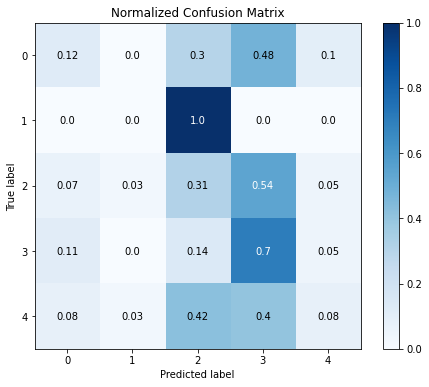

In [98]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

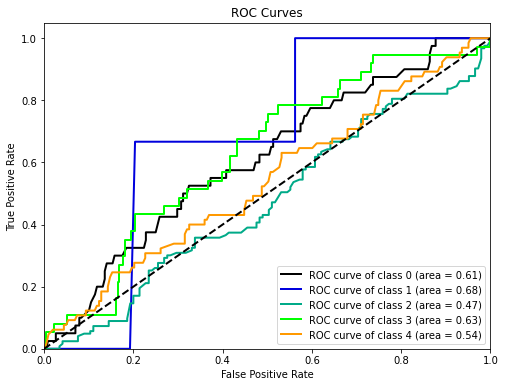

In [99]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

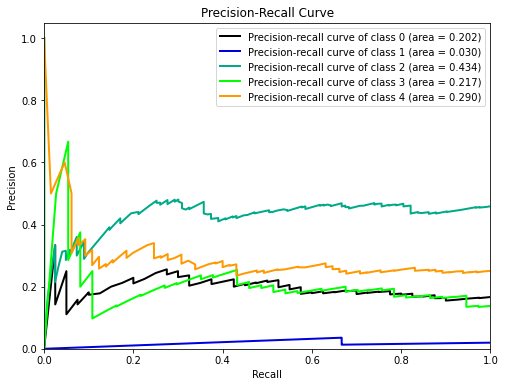

In [100]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.2 RCNN (Concatenation)

Epoch 1/100
22/22 - 3s - loss: 1.9401 - accuracy: 0.2559 - auc_113: 0.5877 - precision_113: 0.3220 - recall_113: 0.0562 - f1_score: 0.1781 - val_loss: 5.6039 - val_accuracy: 0.0395 - val_auc_113: 0.3771 - val_precision_113: 0.0411 - val_recall_113: 0.0395 - val_f1_score: 0.0203 - 3s/epoch - 114ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3921 - accuracy: 0.3550 - auc_113: 0.7038 - precision_113: 0.3797 - recall_113: 0.0888 - f1_score: 0.2455 - val_loss: 6.0855 - val_accuracy: 0.0395 - val_auc_113: 0.3224 - val_precision_113: 0.0152 - val_recall_113: 0.0132 - val_f1_score: 0.0379 - 463ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2139 - accuracy: 0.3935 - auc_113: 0.7357 - precision_113: 0.4786 - recall_113: 0.1820 - f1_score: 0.2900 - val_loss: 3.8081 - val_accuracy: 0.3684 - val_auc_113: 0.6141 - val_precision_113: 0.3733 - val_recall_113: 0.3684 - val_f1_score: 0.1098 - 474ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.0196 - accuracy: 0.4852 - auc_113: 0.7931 - precision_

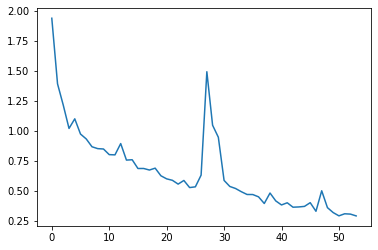

Epoch 1/100
22/22 - 3s - loss: 1.9363 - accuracy: 0.2885 - auc_114: 0.6305 - precision_114: 0.3170 - recall_114: 0.1050 - f1_score: 0.1754 - val_loss: 13.2899 - val_accuracy: 0.2763 - val_auc_114: 0.5470 - val_precision_114: 0.2763 - val_recall_114: 0.2763 - val_f1_score: 0.0866 - 3s/epoch - 115ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3245 - accuracy: 0.3772 - auc_114: 0.7046 - precision_114: 0.4607 - recall_114: 0.1302 - f1_score: 0.2699 - val_loss: 4.4168 - val_accuracy: 0.2763 - val_auc_114: 0.6720 - val_precision_114: 0.2763 - val_recall_114: 0.2763 - val_f1_score: 0.0866 - 481ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.1841 - accuracy: 0.4527 - auc_114: 0.7674 - precision_114: 0.5333 - recall_114: 0.1893 - f1_score: 0.3224 - val_loss: 16.9211 - val_accuracy: 0.1184 - val_auc_114: 0.4490 - val_precision_114: 0.1184 - val_recall_114: 0.1184 - val_f1_score: 0.0424 - 467ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.2013 - accuracy: 0.4379 - auc_114: 0.7652 - precisio

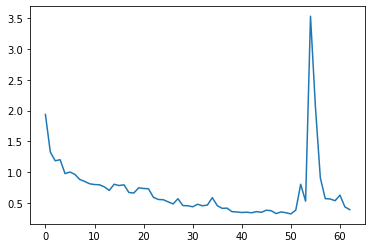

Epoch 1/100
22/22 - 3s - loss: 1.9882 - accuracy: 0.2910 - auc_115: 0.6550 - precision_115: 0.3207 - recall_115: 0.0871 - f1_score: 0.2055 - val_loss: 6.0104 - val_accuracy: 0.3733 - val_auc_115: 0.5550 - val_precision_115: 0.3733 - val_recall_115: 0.3733 - val_f1_score: 0.1822 - 3s/epoch - 115ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3544 - accuracy: 0.3767 - auc_115: 0.7263 - precision_115: 0.4340 - recall_115: 0.1019 - f1_score: 0.2683 - val_loss: 43.5212 - val_accuracy: 0.0133 - val_auc_115: 0.3833 - val_precision_115: 0.0133 - val_recall_115: 0.0133 - val_f1_score: 0.0053 - 467ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.5624 - accuracy: 0.3264 - auc_115: 0.6762 - precision_115: 0.3447 - recall_115: 0.1196 - f1_score: 0.2504 - val_loss: 10.7923 - val_accuracy: 0.0400 - val_auc_115: 0.4082 - val_precision_115: 0.0400 - val_recall_115: 0.0400 - val_f1_score: 0.0156 - 472ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.0872 - accuracy: 0.4165 - auc_115: 0.7709 - precisio

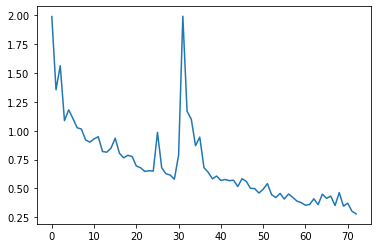

Epoch 1/100
22/22 - 3s - loss: 2.0694 - accuracy: 0.2452 - auc_116: 0.6014 - precision_116: 0.1919 - recall_116: 0.0487 - f1_score: 0.1776 - val_loss: 31.9785 - val_accuracy: 0.0000e+00 - val_auc_116: 0.3750 - val_precision_116: 0.0000e+00 - val_recall_116: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 115ms/step
Epoch 2/100
22/22 - 0s - loss: 1.6297 - accuracy: 0.3309 - auc_116: 0.6495 - precision_116: 0.2452 - recall_116: 0.0561 - f1_score: 0.2228 - val_loss: 1.5423 - val_accuracy: 0.4533 - val_auc_116: 0.7070 - val_precision_116: 0.5581 - val_recall_116: 0.3200 - val_f1_score: 0.2470 - 476ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.3707 - accuracy: 0.3914 - auc_116: 0.7261 - precision_116: 0.4477 - recall_116: 0.1137 - f1_score: 0.2785 - val_loss: 15.7348 - val_accuracy: 0.0800 - val_auc_116: 0.4166 - val_precision_116: 0.0800 - val_recall_116: 0.0800 - val_f1_score: 0.0296 - 461ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.2888 - accuracy: 0.4136 - auc_116: 0

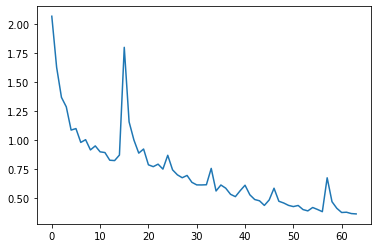

Epoch 1/100
22/22 - 3s - loss: 1.7101 - accuracy: 0.3545 - auc_117: 0.6641 - precision_117: 0.4176 - recall_117: 0.1049 - f1_score: 0.2293 - val_loss: 12.2101 - val_accuracy: 0.1067 - val_auc_117: 0.4417 - val_precision_117: 0.1067 - val_recall_117: 0.1067 - val_f1_score: 0.0386 - 3s/epoch - 114ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3805 - accuracy: 0.4357 - auc_117: 0.7519 - precision_117: 0.5436 - recall_117: 0.1566 - f1_score: 0.3199 - val_loss: 26.2651 - val_accuracy: 0.0667 - val_auc_117: 0.4167 - val_precision_117: 0.0667 - val_recall_117: 0.0667 - val_f1_score: 0.0250 - 465ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2163 - accuracy: 0.4195 - auc_117: 0.7286 - precision_117: 0.4741 - recall_117: 0.1758 - f1_score: 0.3019 - val_loss: 4.3296 - val_accuracy: 0.2000 - val_auc_117: 0.5495 - val_precision_117: 0.2055 - val_recall_117: 0.2000 - val_f1_score: 0.1048 - 476ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.1578 - accuracy: 0.4372 - auc_117: 0.7675 - precisio

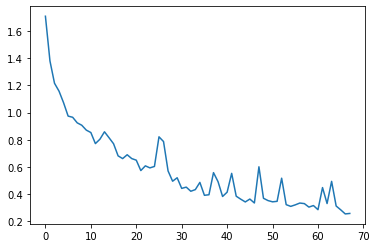

Epoch 1/100
22/22 - 3s - loss: 1.8589 - accuracy: 0.2895 - auc_118: 0.6514 - precision_118: 0.2578 - recall_118: 0.0487 - f1_score: 0.1974 - val_loss: 7.9540 - val_accuracy: 0.3067 - val_auc_118: 0.5442 - val_precision_118: 0.3067 - val_recall_118: 0.3067 - val_f1_score: 0.0958 - 3s/epoch - 132ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3302 - accuracy: 0.3648 - auc_118: 0.6950 - precision_118: 0.3788 - recall_118: 0.0739 - f1_score: 0.2784 - val_loss: 2.3526 - val_accuracy: 0.3067 - val_auc_118: 0.7020 - val_precision_118: 0.3108 - val_recall_118: 0.3067 - val_f1_score: 0.0979 - 483ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2606 - accuracy: 0.4210 - auc_118: 0.7669 - precision_118: 0.5160 - recall_118: 0.1433 - f1_score: 0.3029 - val_loss: 4.2367 - val_accuracy: 0.0933 - val_auc_118: 0.5338 - val_precision_118: 0.0959 - val_recall_118: 0.0933 - val_f1_score: 0.0546 - 463ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.1176 - accuracy: 0.4431 - auc_118: 0.7662 - precision_

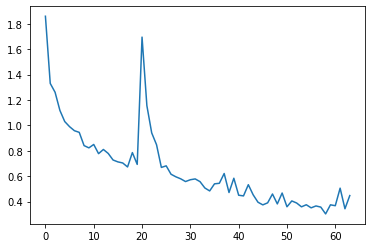

Epoch 1/100
22/22 - 3s - loss: 2.2180 - accuracy: 0.2393 - auc_119: 0.5851 - precision_119: 0.2215 - recall_119: 0.0487 - f1_score: 0.1695 - val_loss: 5.4536 - val_accuracy: 0.4533 - val_auc_119: 0.6562 - val_precision_119: 0.4533 - val_recall_119: 0.4533 - val_f1_score: 0.1283 - 3s/epoch - 115ms/step
Epoch 2/100
22/22 - 0s - loss: 1.5173 - accuracy: 0.3264 - auc_119: 0.6434 - precision_119: 0.3429 - recall_119: 0.0709 - f1_score: 0.2297 - val_loss: 7.6782 - val_accuracy: 0.0000e+00 - val_auc_119: 0.3392 - val_precision_119: 0.0000e+00 - val_recall_119: 0.0000e+00 - val_f1_score: 0.0000e+00 - 464ms/epoch - 21ms/step
Epoch 3/100
22/22 - 0s - loss: 1.3654 - accuracy: 0.3383 - auc_119: 0.6775 - precision_119: 0.3034 - recall_119: 0.0798 - f1_score: 0.2620 - val_loss: 11.5939 - val_accuracy: 0.0533 - val_auc_119: 0.4133 - val_precision_119: 0.0533 - val_recall_119: 0.0533 - val_f1_score: 0.0205 - 466ms/epoch - 21ms/step
Epoch 4/100
22/22 - 1s - loss: 1.3322 - accuracy: 0.4165 - auc_119: 0.

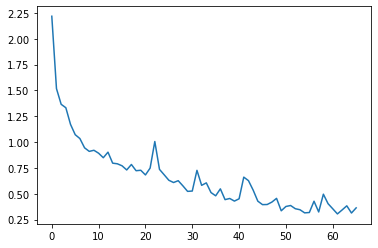

Epoch 1/100
22/22 - 3s - loss: 2.0986 - accuracy: 0.2718 - auc_120: 0.6302 - precision_120: 0.2909 - recall_120: 0.0709 - f1_score: 0.1940 - val_loss: 28.1937 - val_accuracy: 0.0000e+00 - val_auc_120: 0.3750 - val_precision_120: 0.0000e+00 - val_recall_120: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 115ms/step
Epoch 2/100
22/22 - 0s - loss: 1.4837 - accuracy: 0.3516 - auc_120: 0.6714 - precision_120: 0.3144 - recall_120: 0.0901 - f1_score: 0.2403 - val_loss: 17.2221 - val_accuracy: 0.0933 - val_auc_120: 0.4333 - val_precision_120: 0.0933 - val_recall_120: 0.0933 - val_f1_score: 0.0341 - 479ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2440 - accuracy: 0.4328 - auc_120: 0.7466 - precision_120: 0.4851 - recall_120: 0.1448 - f1_score: 0.3277 - val_loss: 12.5331 - val_accuracy: 0.0800 - val_auc_120: 0.3740 - val_precision_120: 0.0800 - val_recall_120: 0.0800 - val_f1_score: 0.0312 - 476ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.1627 - accuracy: 0.4284 - auc_120: 

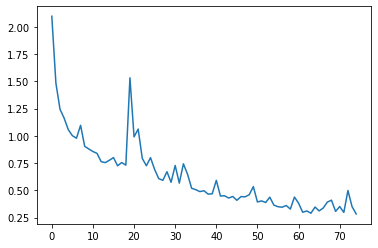

Epoch 1/100
22/22 - 3s - loss: 1.9102 - accuracy: 0.2733 - auc_121: 0.6090 - precision_121: 0.3169 - recall_121: 0.0665 - f1_score: 0.1873 - val_loss: 3.4375 - val_accuracy: 0.3067 - val_auc_121: 0.6225 - val_precision_121: 0.3235 - val_recall_121: 0.2933 - val_f1_score: 0.1519 - 3s/epoch - 114ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3624 - accuracy: 0.3796 - auc_121: 0.7075 - precision_121: 0.4479 - recall_121: 0.1078 - f1_score: 0.2779 - val_loss: 3.2058 - val_accuracy: 0.2533 - val_auc_121: 0.5187 - val_precision_121: 0.2540 - val_recall_121: 0.2133 - val_f1_score: 0.1247 - 481ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.1489 - accuracy: 0.4417 - auc_121: 0.7621 - precision_121: 0.5896 - recall_121: 0.1846 - f1_score: 0.3161 - val_loss: 5.1053 - val_accuracy: 0.3867 - val_auc_121: 0.5595 - val_precision_121: 0.3867 - val_recall_121: 0.3867 - val_f1_score: 0.1776 - 466ms/epoch - 21ms/step
Epoch 4/100
22/22 - 0s - loss: 1.1329 - accuracy: 0.4904 - auc_121: 0.7865 - precision_

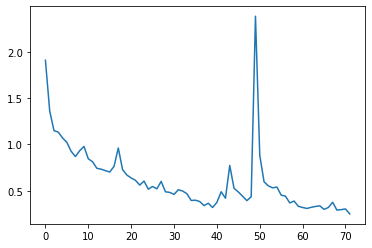

Epoch 1/100
22/22 - 3s - loss: 1.8774 - accuracy: 0.2718 - auc_122: 0.6152 - precision_122: 0.1970 - recall_122: 0.0384 - f1_score: 0.1962 - val_loss: 14.2359 - val_accuracy: 0.0800 - val_auc_122: 0.4250 - val_precision_122: 0.0800 - val_recall_122: 0.0800 - val_f1_score: 0.0296 - 3s/epoch - 115ms/step
Epoch 2/100
22/22 - 0s - loss: 1.3955 - accuracy: 0.3530 - auc_122: 0.6963 - precision_122: 0.4103 - recall_122: 0.0945 - f1_score: 0.2544 - val_loss: 11.1681 - val_accuracy: 0.0800 - val_auc_122: 0.4121 - val_precision_122: 0.0800 - val_recall_122: 0.0800 - val_f1_score: 0.0296 - 474ms/epoch - 22ms/step
Epoch 3/100
22/22 - 0s - loss: 1.2359 - accuracy: 0.3959 - auc_122: 0.7385 - precision_122: 0.4975 - recall_122: 0.1462 - f1_score: 0.2848 - val_loss: 2.9119 - val_accuracy: 0.0933 - val_auc_122: 0.5999 - val_precision_122: 0.0833 - val_recall_122: 0.0800 - val_f1_score: 0.0401 - 474ms/epoch - 22ms/step
Epoch 4/100
22/22 - 0s - loss: 1.0519 - accuracy: 0.4461 - auc_122: 0.7742 - precisio

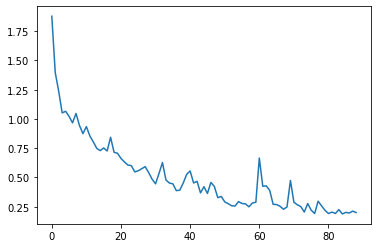

In [101]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_latefusion_model = RCNN(body_features, face_features, n_length, n_outputs, fusion=True, multiclass=True)
    history = rcnn_area_latefusion_model.trainFusioned(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_latefusion_model.save(model_path / 'late_area_rcnn.h5')

#### Training performance

In [102]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.8714483857154847,
 'ROC/AUC': 0.9796763956546783,
 'Precision': 0.8883796513080597,
 'Recall': 0.8470654547214508,
 'F1-score': 0.8020237743854522}

#### Validation performance

In [103]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.4573684215545654,
 'ROC/AUC': 0.7468335717916489,
 'Precision': 0.4707683205604553,
 'Recall': 0.44142105579376223,
 'F1-score': 0.2582074388861656}

#### Predictions and performance on test set

In [104]:
rcnn_area_latefusion_model = load_model(model_path / 'late_area_rcnn.h5')
y_pred = rcnn_area_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_area_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 0s 7ms/step - loss: 1.9128 - accuracy: 0.2799 - auc_115: 0.6510 - precision_115: 0.2561 - recall_115: 0.1567 - f1_score: 0.1914
Accuracy: 27.99% 
ROC/AUC: 0.65 
Precision: 0.26 
Recall: 0.16 
F1 score: 0.19


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

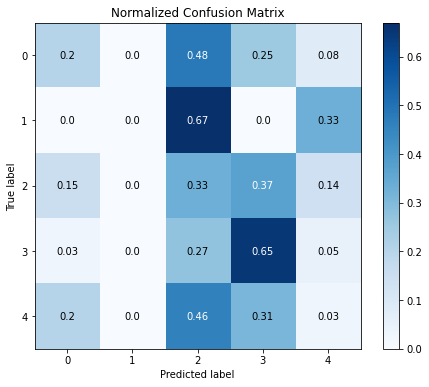

In [105]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

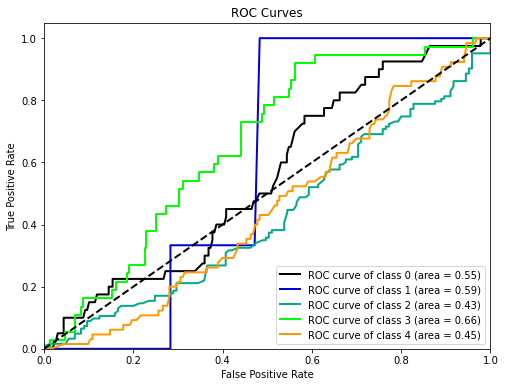

In [106]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

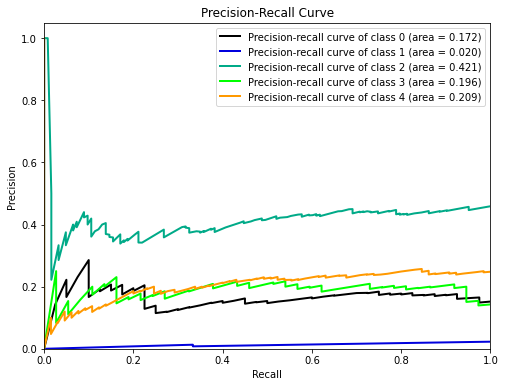

In [107]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.3 Ensemble

In [108]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_area_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_area_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_area_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_area_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [109]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [110]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.4370)
RCNN Body Model (weight: 0.0003)
CNN + Bidirectional LSTM Face Model (weight: 0.0003)
RCNN Face Model (weight: 0.5624)
Accuracy: 35.07% - ROC/AUC: 0.58 - Precision: 0.40 - Recall: 0.29 - F1 score: 0.22


## Results

ValueError: shape mismatch: objects cannot be broadcast to a single shape

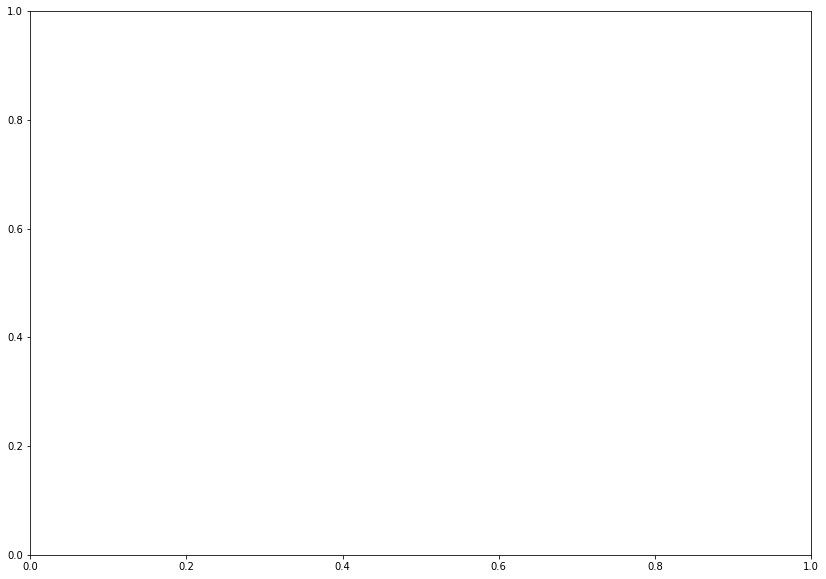

: 

In [111]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnn_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Pain Area Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()